In [5]:
import rasterio as rio
import matplotlib.pyplot as plt 
from matplotlib.colors import Normalize
import numpy as np
import numpy.matlib
from scipy import interpolate
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as st
import scipy
import os, sys, pickle, gzip
import datetime
import geopy.distance
import xarray as xr
import pandas as pd
import geopandas as gpd
import shapely.geometry
import shapely.ops
import cartopy
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
import itertools
import random
import metpy
from metpy.plots import USCOUNTIES
from pyts.decomposition import SingularSpectrumAnalysis

import warnings
warnings.filterwarnings('ignore')

dataDirDiscovery = '/dartfs-hpc/rc/lab/C/CMIG/ecoffel/data/projects/ag-land-climate'

In [6]:
run ../util/setupConsole

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# low and high temps for gdd/kdd calcs, taken from Butler, et al, 2015, ERL
t_low = 9
t_high = 29

crop = 'Maize'
wxData = 'era5'

useTrendMethod = True

yearRange = [1981, 2019]

In [8]:
sacksLat = np.linspace(90, -90, 360)
sacksLon = np.linspace(0, 360, 720)

In [9]:
# # load gdd/kdd from cpc temperature data
# if wxData == 'gldas':
#     gdd = np.full([len(sacksLat), len(sacksLon), (yearRange[1]-yearRange[0]+1)], np.nan)
#     kdd = np.full([len(sacksLat), len(sacksLon), (yearRange[1]-yearRange[0]+1)], np.nan)
    
#     for y, year in enumerate(np.arange(yearRange[0], yearRange[1]+1)):
#         with gzip.open('%s/kdd-cpc-%s-%d.dat'%(dataDirDiscovery, crop, year), 'rb') as f:
#             curKdd = pickle.load(f)
#             kdd[:, :, y] = curKdd

#         with gzip.open('%s/gdd-cpc-%s-%d.dat'%(dataDirDiscovery, crop, year), 'rb') as f:
#             curGdd = pickle.load(f)
#             gdd[:, :, y] = curGdd
    
#     with gzip.open('%s/gdd-kdd-lat-cpc.dat'%(dataDirDiscovery), 'rb') as f:
#         lat = pickle.load(f)

#     with gzip.open('%s/gdd-kdd-lon-cpc.dat'%(dataDirDiscovery), 'rb') as f:
#         lon = pickle.load(f)
        
# elif wxData == 'era5':
#     gdd = np.full([721, 1440, (yearRange[1]-yearRange[0]+1)], np.nan)
#     kdd = np.full([721, 1440, (yearRange[1]-yearRange[0]+1)], np.nan)

#     for y, year in enumerate(np.arange(yearRange[0], yearRange[1]+1)):
#         with gzip.open('%s/kdd-%s-%s-%d.dat'%(dataDirDiscovery, wxData, crop, year), 'rb') as f:
#             curKdd = pickle.load(f)
#             kdd[:, :, y] = curKdd

#         with gzip.open('%s/gdd-%s-%s-%d.dat'%(dataDirDiscovery, wxData, crop, year), 'rb') as f:
#             curGdd = pickle.load(f)
#             gdd[:, :, y] = curGdd

#     with gzip.open('%s/gdd-kdd-lat-%s.dat'%(dataDirDiscovery, wxData), 'rb') as f:
#         lat = pickle.load(f)

#     with gzip.open('%s/gdd-kdd-lon-%s.dat'%(dataDirDiscovery, wxData), 'rb') as f:
#         lon = pickle.load(f)


In [10]:
usStateAbbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Palau': 'PW',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
}

In [11]:
minCropYears = 10
minCropYearsDeepak = 10

rebuild=False

if os.path.isfile('%s/us-county-yield-gdd-kdd-%s-%s'%(dataDirDiscovery, crop, wxData)) and not rebuild:
    usCounties = pd.read_pickle('%s/us-county-yield-gdd-kdd-%s-%s'%(dataDirDiscovery, crop, wxData))


In [12]:
usCounties = usCounties.drop(columns=['CWA', 'TIME_ZONE', 'FE_AREA'])

In [13]:
# drop all counties with any nans
yieldNans = np.array(list(map(np.isnan, usCounties['maizeYield'])))
yieldTrendNans = np.array(list(map(np.isnan, usCounties['maizeYieldTrend'])))
gddNans = np.array(list(map(np.isnan, usCounties['gdd'])))
kddNans = np.array(list(map(np.isnan, usCounties['kdd'])))
# inds1 = np.where( (np.array([len(np.where((yieldNans[i]==False) & ((gddNans[i]==True) | (kddNans[i]==True)))[0]) for i in range(len(yieldNans))]) > 0))[0]
inds = np.where((yieldTrendNans == True))[0]
# inds = np.union1d(inds1, inds2)

In [14]:
usCounties = usCounties.drop(index=inds)

In [15]:
countyMaizeHaAc = np.array([a for a in np.array(list(usCounties['maizeHarvestedArea']))])
countyMaizeHaMeanAc = np.array([np.nanmean(a) for a in np.array(list(usCounties['maizeHarvestedArea']))])
countySoybeanHaAc = np.array([a for a in np.array(list(usCounties['soybeanHarvestedArea']))])
countySoybeanHaMeanAc = np.array([np.nanmean(a) for a in np.array(list(usCounties['soybeanHarvestedArea']))])

countyMaizeYieldDetrend = np.array(list(usCounties['maizeYieldDetrendPlusMean']))
countyMaizeYield = np.array(list(usCounties['maizeYield']))
countyMaizeYieldDetrendAnom = np.array(list(usCounties['maizeYieldDetrend']))

countySoybeanYieldDetrend = np.array(list(usCounties['soybeanYieldDetrendPlusMean']))
countySoybeanYield = np.array(list(usCounties['soybeanYield']))
countySoybeanYieldDetrendAnom = np.array(list(usCounties['soybeanYieldDetrend']))

countyTotalProd = np.array([y*a for y,a in zip(countyMaizeYield, countyMaizeHaAc)] + [y*a for y,a in zip(countySoybeanYield, countySoybeanHaAc)])

In [53]:
%%time
# CURRENT VERSION - 2020-09-02

from sklearn.preprocessing import normalize

curCountyList = usCounties.copy()

useDeepak = False

uncertaintyProp = False

n_bootstraps = 1
sample_x = np.linspace(0.05, .95, 4)

adjustForHarvestedArea = False

areaLimit = [30]
irrLimit = 10

useSsa = False

ssa = SingularSpectrumAnalysis(window_size=.5, groups=None)

def ssaDetrend(x):
    ssafit = ssa.fit_transform(x.reshape(1,-1))
    return x-ssafit[0,:]

def normWithNan(x):
    x1d = np.reshape(x, [x.size])
    nn = np.where(~np.isnan(x1d))[0]
    x1d = x1d[nn]
    x_norm = x.copy()/np.linalg.norm(x1d)
    return x_norm


haMeanAggAll = np.nanmean(np.array([a for a in usCounties['maizeHarvestedAreaFraction']]), axis=1)*100
irAggAll = np.array([a for a in usCounties['maizeCountyIrrigationFraction']])

countyAcAll = np.array([np.nanmean(a) for a in usCounties['maizeCountyArea']])
haMaizeAllAc = np.array([a for a in usCounties['maizeHarvestedArea']])
haSoybeanAllAc = np.array([a for a in usCounties['soybeanHarvestedArea']])
haMaizeMeanAllAc = np.array([np.nanmean(a) for a in usCounties['maizeHarvestedArea']])
haSoybeanMeanAllAc = np.array([np.nanmean(a) for a in usCounties['soybeanHarvestedArea']])
haTotalAllAc = haMaizeMeanAllAc + haSoybeanMeanAllAc
haTotalFracAll = haTotalAllAc/countyAcAll

countySeasonLenSec = np.array(list(curCountyList['seasonalSeconds']))

if useDeepak:
    countyYieldDetrend = np.array(list(curCountyList['maizeYieldDetrendPlusMeanDeepak'])) 
    countyYield = np.array(list(curCountyList['maizeYieldDeepak']))
    countyYieldDetrendAnom = np.array(list(curCountyList['maizeYieldDetrendDeepak']))
else:
    countyMaizeHaAc = np.array([a for a in np.array(list(usCounties['maizeHarvestedArea']))])
    countyMaizeHaMeanAc = np.array([np.nanmean(a) for a in np.array(list(usCounties['maizeHarvestedArea']))])
    countyMaizeHaFrac = np.array([a for a in np.array(list(usCounties['maizeHarvestedAreaFraction']))])*100
    countySoybeanHaAc = np.array([a for a in np.array(list(usCounties['soybeanHarvestedArea']))])
    countySoybeanHaMeanAc = np.array([np.nanmean(a) for a in np.array(list(usCounties['soybeanHarvestedArea']))])
    countySoybeanHaFrac = np.array([a for a in np.array(list(usCounties['soybeanHarvestedAreaFraction']))])*100

    countyMaizeYield = np.array(list(curCountyList['maizeYield']))
    countyMaizeYieldDetrendAnom = np.array(list(curCountyList['maizeYieldDetrend']))

    countySoybeanYield = np.array(list(curCountyList['soybeanYield']))
    countySoybeanYieldDetrendAnom = np.array(list(curCountyList['soybeanYieldDetrend']))

    countyTotalProd = np.full(countySoybeanYield.shape, np.nan)
    for c in range(countyTotalProd.shape[0]):
        p_maize = np.array([x[0]*x[1] for x in zip(countyMaizeYield[c,:], countyMaizeHaAc[c,:])])
        p_soybean = np.array([x[0]*x[1] for x in zip(countySoybeanYield[c,:], countySoybeanHaAc[c,:])])
        countyTotalProd[c,:] = p_maize + p_soybean


countyIr = np.array(list(usCounties['maizeCountyIrrigationFraction']))
countyState = np.array(list(usCounties['STATE']))
countyFips = np.array(list(usCounties['FIPS']))

countyPr = np.array(list(curCountyList['seasonalPrecip']))  # mm
if wxData == 'era5':
    countyT = np.array(list(curCountyList['seasonalT']))  # growing season mean monthly temperature
countyKdd = np.array(list(curCountyList['kdd']))
countyGdd = np.array(list(curCountyList['gdd']))

# now these are in w/m2
countySlhf = -np.array(list(curCountyList['seasonalSlhf']))
countySshf = -np.array(list(curCountyList['seasonalSshf']))
countySsr = np.array(list(curCountyList['seasonalSsr']))
countyStr = np.array(list(curCountyList['seasonalStr']))

if wxData == 'era5':
    # convert from J/growing season/m2 to W/m2
    countySlhf /= np.matlib.repmat(countySeasonLenSec, 39, 1).T
    countySshf /= np.matlib.repmat(countySeasonLenSec, 39, 1).T
    countySsr /= np.matlib.repmat(countySeasonLenSec, 39, 1).T
    countyStr /= np.matlib.repmat(countySeasonLenSec, 39, 1).T

countyNetRad = (countySsr+countyStr)
countyU10 = np.array(list(curCountyList['seasonalU10']))
countyV10 = np.array(list(curCountyList['seasonalV10']))

if wxData == 'era5':
    countyT_Norm = normWithNan(countyT)
countyPr_Norm = normWithNan(countyPr)
countyKdd_Norm = normWithNan(countyKdd)
countyGdd_Norm = normWithNan(countyGdd)
countySlhf_Norm = normWithNan(countySlhf)
countySshf_Norm = normWithNan(countySshf)
countyNetRad_Norm = normWithNan(countyNetRad)
countyU10_Norm = normWithNan(countyU10)
countyV10_Norm = normWithNan(countyV10)
countyMaizeYield_Norm = normWithNan(countyMaizeYield)
countySoybeanYield_Norm = normWithNan(countySoybeanYield)
countyTotalProd_Norm = normWithNan(countyTotalProd)

NCounties = countyKdd.shape[0]
NYears = countyKdd.shape[1]

maizeYieldFromFeedback_SensTest = np.full([NCounties, len(sample_x), n_bootstraps, len(areaLimit)], np.nan)
soybeanYieldFromFeedback_SensTest = np.full([NCounties, len(sample_x), n_bootstraps, len(areaLimit)], np.nan)

for a, curAreaLimit in enumerate(areaLimit):
    
    if len(areaLimit) > 1:
        print('area limit %d%%'%curAreaLimit)

    lhTrendFrac = np.full([NCounties, len(sample_x), n_bootstraps], np.nan)
    shTrendFrac = np.full([NCounties, len(sample_x), n_bootstraps], np.nan)
    lhFromFeedback = np.full([NCounties, len(sample_x), n_bootstraps], np.nan)
    shFromFeedback = np.full([NCounties, len(sample_x), n_bootstraps], np.nan)
    if wxData == 'era5':
        tFromFeedback = np.full([NCounties, len(sample_x), n_bootstraps], np.nan)
    kddTrendFrac = np.full([NCounties, len(sample_x), n_bootstraps], np.nan)
    kddFromFeedback = np.full([NCounties, len(sample_x), n_bootstraps], np.nan)
    gddTrendFrac = np.full([NCounties, len(sample_x), n_bootstraps], np.nan)
    gddFromFeedback = np.full([NCounties, len(sample_x), n_bootstraps], np.nan)
    maizeYieldTrendFrac = np.full([NCounties, len(sample_x), n_bootstraps], np.nan)
    maizeYieldFromFeedback = np.full([NCounties, len(sample_x), n_bootstraps], np.nan)
    soybeanYieldTrendFrac = np.full([NCounties, len(sample_x), n_bootstraps], np.nan)
    soybeanYieldFromFeedback = np.full([NCounties, len(sample_x), n_bootstraps], np.nan)
    prodFromFeedback = np.full([NCounties, len(sample_x), n_bootstraps], np.nan)

    maizeYieldChgFeedbackWithAgInt = np.full([NCounties, len(sample_x), n_bootstraps], np.nan)
    maizeYieldChgFeedbackWithoutAgInt = np.full([NCounties, len(sample_x), n_bootstraps], np.nan)

    soybeanYieldChgFeedbackWithAgInt = np.full([NCounties, len(sample_x), n_bootstraps], np.nan)
    soybeanYieldChgFeedbackWithoutAgInt = np.full([NCounties, len(sample_x), n_bootstraps], np.nan)

    lhChgFeedbackWithAgInt = np.full([NCounties, len(sample_x), n_bootstraps], np.nan)
    lhChgFeedbackWithoutAgInt = np.full([NCounties, len(sample_x), n_bootstraps], np.nan)

    shChgFeedbackWithAgInt = np.full([NCounties, len(sample_x), n_bootstraps], np.nan)
    shChgFeedbackWithoutAgInt = np.full([NCounties, len(sample_x), n_bootstraps], np.nan)

    kddChgFeedbackWithAgInt = np.full([NCounties, len(sample_x), n_bootstraps], np.nan)
    kddChgFeedbackWithoutAgInt = np.full([NCounties, len(sample_x), n_bootstraps], np.nan)

    gddChgFeedbackWithAgInt = np.full([NCounties, len(sample_x), n_bootstraps], np.nan)
    gddChgFeedbackWithoutAgInt = np.full([NCounties, len(sample_x), n_bootstraps], np.nan)

    lhObsTrend = np.full([NCounties], np.nan)
    shObsTrend = np.full([NCounties], np.nan)
    netRadObsTrend = np.full([NCounties], np.nan)

    lhMod_yieldGrowth = np.full([NCounties, NYears, len(sample_x), n_bootstraps], np.nan)
    lhMod_noYieldGrowth = np.full([NCounties, NYears, len(sample_x), n_bootstraps], np.nan)
    lhModTrend_yieldGrowth = np.full([NCounties, len(sample_x), n_bootstraps], np.nan)
    lhModTrend_noYieldGrowth = np.full([NCounties, len(sample_x), n_bootstraps], np.nan)

    shMod_yieldGrowth = np.full([NCounties, NYears, len(sample_x), n_bootstraps], np.nan)
    shMod_noYieldGrowth = np.full([NCounties, NYears, len(sample_x), n_bootstraps], np.nan)
    shModTrend_yieldGrowth = np.full([NCounties, len(sample_x), n_bootstraps], np.nan)
    shModTrend_noYieldGrowth = np.full([NCounties, len(sample_x), n_bootstraps], np.nan)

    if wxData == 'era5':
        tMod_yieldGrowth = np.full([NCounties, NYears, len(sample_x), n_bootstraps], np.nan)
        tMod_noYieldGrowth = np.full([NCounties, NYears, len(sample_x), n_bootstraps], np.nan)
        tModTrend_yieldGrowth = np.full([NCounties, len(sample_x), n_bootstraps], np.nan)
        tModTrend_noYieldGrowth = np.full([NCounties, len(sample_x), n_bootstraps], np.nan)
    
    gddMod_yieldGrowth = np.full([NCounties, NYears, len(sample_x), n_bootstraps], np.nan)
    gddMod_noYieldGrowth = np.full([NCounties, NYears, len(sample_x), n_bootstraps], np.nan)
    gddModTrend_yieldGrowth = np.full([NCounties, len(sample_x), n_bootstraps], np.nan)
    gddModTrend_noYieldGrowth = np.full([NCounties, len(sample_x), n_bootstraps], np.nan)

    kddMod_yieldGrowth = np.full([NCounties, NYears, len(sample_x), n_bootstraps], np.nan)
    kddMod_noYieldGrowth = np.full([NCounties, NYears, len(sample_x), n_bootstraps], np.nan)
    kddModTrend_yieldGrowth = np.full([NCounties, len(sample_x), n_bootstraps], np.nan)
    kddModTrend_noYieldGrowth = np.full([NCounties, len(sample_x), n_bootstraps], np.nan)

    maizeYieldMod_yieldGrowth = np.full([NCounties, NYears, len(sample_x), n_bootstraps], np.nan)
    maizeYieldMod_noYieldGrowth = np.full([NCounties, NYears, len(sample_x), n_bootstraps], np.nan)
    maizeYieldModTrend_yieldGrowth = np.full([NCounties, len(sample_x), n_bootstraps], np.nan)
    maizeYieldModTrend_noYieldGrowth = np.full([NCounties, len(sample_x), n_bootstraps], np.nan)

    soybeanYieldMod_yieldGrowth = np.full([NCounties, NYears, len(sample_x), n_bootstraps], np.nan)
    soybeanYieldMod_noYieldGrowth = np.full([NCounties, NYears, len(sample_x), n_bootstraps], np.nan)
    soybeanYieldModTrend_yieldGrowth = np.full([NCounties, len(sample_x), n_bootstraps], np.nan)
    soybeanYieldModTrend_noYieldGrowth = np.full([NCounties, len(sample_x), n_bootstraps], np.nan)

    mdl_Param_Corr = {'Prod-Pr':np.full([NCounties], np.nan), 
                        'Prod-NetRad':np.full([NCounties], np.nan), 
                      'Prod-Wind':np.full([NCounties], np.nan), 
                      'Pr-NetRad':np.full([NCounties], np.nan), 
                      'Pr-Wind':np.full([NCounties], np.nan), 
                      'NetRad-Wind':np.full([NCounties], np.nan)}

    mdl_LH_Y_Coefs = {'MaizeYield_DetrendAnom':np.full([NCounties], np.nan), 
                      'SoybeanYield_DetrendAnom':np.full([NCounties], np.nan), 
                      'TotalProd_DetrendAnom':np.full([NCounties], np.nan), 
                           'Pr_DetrendAnom':np.full([NCounties], np.nan),
                           'NetRad_DetrendAnom':np.full([NCounties], np.nan),
                           'Wind_DetrendAnom':np.full([NCounties], np.nan), 
                         'R2':np.full([NCounties], np.nan)}
    mdl_LH_Y_PValues = {'MaizeYield_DetrendAnom':np.full([NCounties], np.nan), 
                        'SoybeanYield_DetrendAnom':np.full([NCounties], np.nan), 
                        'TotalProd_DetrendAnom':np.full([NCounties], np.nan), 
                           'Pr_DetrendAnom':np.full([NCounties], np.nan),
                           'NetRad_DetrendAnom':np.full([NCounties], np.nan),
                           'Wind_DetrendAnom':np.full([NCounties], np.nan)}
    

    mdl_LH_Y_Norm_Coefs = {'MaizeYield_DetrendAnom_Norm':np.full([NCounties], np.nan), 
                           'SoybeanYield_DetrendAnom_Norm':np.full([NCounties], np.nan), 
                           'TotalProd_DetrendAnom_Norm':np.full([NCounties], np.nan), 
                           'Pr_DetrendAnom_Norm':np.full([NCounties], np.nan),
                           'NetRad_DetrendAnom_Norm':np.full([NCounties], np.nan),
                           'Wind_DetrendAnom_Norm':np.full([NCounties], np.nan)}
    mdl_LH_Y_Norm_PValues = {'MaizeYield_DetrendAnom_Norm':np.full([NCounties], np.nan), 
                             'SoybeanYield_DetrendAnom_Norm':np.full([NCounties], np.nan), 
                             'TotalProd_DetrendAnom_Norm':np.full([NCounties], np.nan), 
                           'Pr_DetrendAnom_Norm':np.full([NCounties], np.nan),
                           'NetRad_DetrendAnom_Norm':np.full([NCounties], np.nan),
                           'Wind_DetrendAnom_Norm':np.full([NCounties], np.nan)}

    mdl_LH_Y_Decomp_Coefs = {'TotalYield_DetrendAnom':np.full([NCounties], np.nan), 
                              'TotalHA':np.full([NCounties], np.nan)}
    mdl_LH_Y_Decomp_PValues = {'TotalYield_DetrendAnom':np.full([NCounties], np.nan), 
                              'TotalHA':np.full([NCounties], np.nan)}

    mdl_LH_SH_Coefs = {'SLHF_DetrendAnom':np.full([NCounties], np.nan), 
                           'NetRad_DetrendAnom':np.full([NCounties], np.nan),
                          'R2':np.full([NCounties], np.nan)}
    mdl_LH_SH_PValues = {'SLHF_DetrendAnom':np.full([NCounties], np.nan), 
                           'NetRad_DetrendAnom':np.full([NCounties], np.nan)}

    mdl_LH_SH_Norm_Coefs = {'SLHF_DetrendAnom_Norm':np.full([NCounties], np.nan), 
                           'NetRad_DetrendAnom_Norm':np.full([NCounties], np.nan)}
    mdl_LH_SH_Norm_PValues = {'SLHF_DetrendAnom_Norm':np.full([NCounties], np.nan), 
                           'NetRad_DetrendAnom_Norm':np.full([NCounties], np.nan)}

    mdl_SH_KDD_Coefs = {'SSHF_DetrendAnom':np.full([NCounties], np.nan),
                       'R2':np.full([NCounties], np.nan)}
    mdl_SH_KDD_PValues = {'SSHF_DetrendAnom':np.full([NCounties], np.nan)}
    mdl_SH_GDD_Coefs = {'SSHF_DetrendAnom':np.full([NCounties], np.nan), 
                       'R2':np.full([NCounties], np.nan)}
    mdl_SH_GDD_PValues = {'SSHF_DetrendAnom':np.full([NCounties], np.nan)}

    mdl_SH_KDD_Norm_Coefs = {'SSHF_DetrendAnom_Norm':np.full([NCounties], np.nan)}
    mdl_SH_KDD_Norm_PValues = {'SSHF_DetrendAnom_Norm':np.full([NCounties], np.nan)}
    mdl_SH_GDD_Norm_Coefs = {'SSHF_DetrendAnom_Norm':np.full([NCounties], np.nan)}
    mdl_SH_GDD_Norm_PValues = {'SSHF_DetrendAnom_Norm':np.full([NCounties], np.nan)}

    mdl_KDD_GDD_MaizeYield_Coefs = {'KDD_Detrend':np.full([NCounties], np.nan),
                                    'GDD_Detrend':np.full([NCounties], np.nan), 
                                    'Pr_Detrend':np.full([NCounties], np.nan),
                                    'R2':np.full([NCounties], np.nan)}
    mdl_KDD_GDD_MaizeYield_PValues = {'KDD_Detrend':np.full([NCounties], np.nan),
                                      'GDD_Detrend':np.full([NCounties], np.nan), 
                                      'Pr_Detrend':np.full([NCounties], np.nan)}

    mdl_KDD_GDD_MaizeYield_Norm_Coefs = {'KDD_DetrendNorm':np.full([NCounties], np.nan),
                                    'GDD_DetrendNorm':np.full([NCounties], np.nan), 
                                    'Pr_DetrendNorm':np.full([NCounties], np.nan),
                                    'R2':np.full([NCounties], np.nan)}
    mdl_KDD_GDD_MaizeYield_Norm_PValues = {'KDD_DetrendNorm':np.full([NCounties], np.nan),
                                      'GDD_DetrendNorm':np.full([NCounties], np.nan), 
                                      'Pr_DetrendNorm':np.full([NCounties], np.nan)}

    mdl_KDD_GDD_SoybeanYield_Coefs = {'KDD_Detrend':np.full([NCounties], np.nan),
                                    'GDD_Detrend':np.full([NCounties], np.nan), 
                                    'Pr_Detrend':np.full([NCounties], np.nan),
                                    'R2':np.full([NCounties], np.nan)}
    mdl_KDD_GDD_SoybeanYield_PValues = {'KDD_Detrend':np.full([NCounties], np.nan),
                                      'GDD_Detrend':np.full([NCounties], np.nan), 
                                      'Pr_Detrend':np.full([NCounties], np.nan)}

    mdl_KDD_GDD_SoybeanYield_Norm_Coefs = {'KDD_DetrendNorm':np.full([NCounties], np.nan),
                                    'GDD_DetrendNorm':np.full([NCounties], np.nan), 
                                    'Pr_DetrendNorm':np.full([NCounties], np.nan),
                                    'R2':np.full([NCounties], np.nan)}
    mdl_KDD_GDD_SoybeanYield_Norm_PValues = {'KDD_DetrendNorm':np.full([NCounties], np.nan),
                                      'GDD_DetrendNorm':np.full([NCounties], np.nan), 
                                      'Pr_DetrendNorm':np.full([NCounties], np.nan)}
    
    mdl_LH_Y_CondNum = np.full([NCounties, n_bootstrap], np.nan)
    mdl_LH_SH_CondNum = np.full([NCounties, n_bootstrap], np.nan)
    mdl_SH_KDD_CondNum = np.full([NCounties, n_bootstrap], np.nan)
    mdl_SH_GDD_CondNum = np.full([NCounties, n_bootstrap], np.nan)
    mdl_KDD_GDD_PR_MaizeYield_CondNum = np.full([NCounties, n_bootstrap], np.nan)
    mdl_KDD_GDD_PR_SoybeanYield_CondNum = np.full([NCounties, n_bootstrap], np.nan)
    
    fipsSel = []
    fipsAll = []
    irSel = []
    haExclude = []
    shortSeriesExclude = []
    nonSigExclude = []
    stateSel = []

    for i in range(NCounties):

        fipsAll.append(countyFips[i])

        if i % 200 == 0:
            print('%d of %d'%(i, NCounties))

        curMaizeYieldDetrendAnom = countyMaizeYieldDetrendAnom[i,:]
        curMaizeYield = countyMaizeYield[i,:]
        curMaizeYield_Norm = countyMaizeYield_Norm[i,:]

        curSoybeanYieldDetrendAnom = countySoybeanYieldDetrendAnom[i,:]
        curSoybeanYield = countySoybeanYield[i,:]
        curSoybeanYield_Norm = countySoybeanYield_Norm[i,:]

        curTotalProd = countyTotalProd[i,:]
        curTotalProd_Norm = countyTotalProd_Norm[i,:]

        curTotalHaFrac = (haMaizeAllAc[i,:] + haSoybeanAllAc[i,:])/countyAcAll[i]

        curKdd = countyKdd[i,:]
        curKdd_Norm = countyKdd_Norm[i,:]
        curGdd = countyGdd[i,:]
        curGdd_Norm = countyGdd_Norm[i,:]
        if wxData == 'era5':
            curT = countyT[i,:]
            curT_Norm = countyT_Norm[i,:]
        curSshf = countySshf[i,:]
        curSshf_Norm = countySshf_Norm[i,:]
        curSlhf = countySlhf[i,:]
        curSlhf_Norm = countySlhf_Norm[i,:]
        curNetRad = countyNetRad[i,:]
        curNetRad_Norm = countyNetRad_Norm[i,:]
        curU10 = countyU10[i,:]
        curU10_Norm = countyU10_Norm[i,:]
        curV10 = countyV10[i,:]
        curV10_Norm = countyV10_Norm[i,:]
        curPr = countyPr[i,:]
        curPr_Norm = countyPr_Norm[i,:]

        nnProd = np.where((~np.isnan(curKdd)) & (~np.isnan(curPr)) & \
                          (~np.isnan(curTotalProd)) & (~np.isnan(curSshf)) & (~np.isnan(curSlhf)))[0]
        nnMaize = np.where((~np.isnan(curKdd)) & (~np.isnan(curPr)) & \
                          (~np.isnan(curMaizeYield)) & (~np.isnan(curSshf)) & (~np.isnan(curSlhf)))[0]
        nnSoybean = np.where((~np.isnan(curKdd)) & (~np.isnan(curPr)) & \
                          (~np.isnan(curSoybeanYield)) & (~np.isnan(curSshf)) & (~np.isnan(curSlhf)))[0]

        stateSel.append(countyState[i])

        exclude = False
        # identify counties excluded bc they have a short production time series
        if np.nansum(curTotalProd) == 0 or len(nnProd) < 10:
            shortSeriesExclude.append(countyFips[i])
            fipsSel.append(np.nan)
            exclude = True

        # identify counties excluded bc they have too little harvested area
        if np.nanmean(countyMaizeHaFrac[i,:]+countySoybeanHaFrac[i,:]) < curAreaLimit:
            haExclude.append(countyFips[i])
            if not exclude: fipsSel.append(np.nan)
            exclude = True

        # identify counties that are irrigated
        if countyIr[i] > (irrLimit/100)*np.nanmean(countyMaizeHaFrac[i,:]+countySoybeanHaFrac[i,:]):
            irSel.append(i)
        else:
            irSel.append(np.nan)

        if exclude:
            continue
        
        # BOOTSTRAP INDEX SELECTION
        for b in range(n_bootstraps):
            nnProd_boot_ind = np.random.choice(np.arange(len(nnProd)), len(nnProd))
            nnMaize_boot_ind = np.random.choice(np.arange(len(nnMaize)), len(nnMaize))
            nnSoybean_boot_ind = np.random.choice(np.arange(len(nnSoybean)), len(nnSoybean))

            # remove linear intercept from yield time series
            if len(nnMaize) >= 10:
                X = sm.add_constant(range(len(curMaizeYield[nnMaize])))
                mdl = sm.OLS(curMaizeYield[nnMaize], X).fit()
                curMaizeYieldIntercept = mdl.params[0]

                X = sm.add_constant(range(len(curMaizeYield_Norm[nnMaize])))
                mdl = sm.OLS(curMaizeYield_Norm[nnMaize], X).fit()
                curMaizeYieldIntercept_Norm = mdl.params[0]

            if len(nnSoybean) >= 10:
                X = sm.add_constant(range(len(curSoybeanYield[nnSoybean])))
                mdl = sm.OLS(curSoybeanYield[nnSoybean], X).fit()
                curSoybeanYieldIntercept = mdl.params[0]

                X = sm.add_constant(range(len(curSoybeanYield_Norm[nnSoybean])))
                mdl = sm.OLS(curSoybeanYield_Norm[nnSoybean], X).fit()
                curSoybeanYieldIntercept_Norm = mdl.params[0]

            X = sm.add_constant(range(len(curTotalProd[nnProd])))
            mdl = sm.OLS(curTotalProd[nnProd], X).fit()
            curTotalProdIntercept = mdl.params[0]

            X = sm.add_constant(range(len(curTotalProd_Norm[nnProd])))
            mdl = sm.OLS(curTotalProd_Norm[nnProd], X).fit()
            curTotalProdIntercept_Norm = mdl.params[0]

            X = sm.add_constant(range(len(curPr)))
            mdl = sm.OLS(curPr, X).fit()
            curPrIntercept = mdl.params[0]

            X = sm.add_constant(range(len((curNetRad))))
            mdl = sm.OLS((curNetRad), X).fit()
            curNetRadIntercept = mdl.params[0]

            X = sm.add_constant(range(len(curU10)))
            mdl = sm.OLS(curU10, X).fit()
            curU10Intercept = mdl.params[0]

            X = sm.add_constant(range(len(curV10)))
            mdl = sm.OLS(curV10, X).fit()
            curV10Intercept = mdl.params[0]

            curWindProd = (curU10[nnProd]**2 + curV10[nnProd]**2)**.5
            curWindProd_Norm = (curU10_Norm[nnProd]**2 + curV10_Norm[nnProd]**2)**.5
            curWindMaize = (curU10[nnMaize]**2 + curV10[nnMaize]**2)**.5
            curWindMaize_Norm = (curU10_Norm[nnMaize]**2 + curV10_Norm[nnMaize]**2)**.5
            curWindSoybean = (curU10[nnSoybean]**2 + curV10[nnSoybean]**2)**.5
            curWindSoybean_Norm = (curU10_Norm[nnSoybean]**2 + curV10_Norm[nnSoybean]**2)**.5

            dataProd = {'KDD_DetrendAnom_Norm':scipy.signal.detrend(curKdd_Norm[nnProd]), \
                    'KDD_DetrendAnom':scipy.signal.detrend(curKdd[nnProd]), \
                    'KDD_DetrendAnom_SSA':ssaDetrend(curKdd[nnProd]), \
                    'KDD_DetrendNorm':scipy.signal.detrend(curKdd_Norm[nnProd])+np.nanmean(curKdd_Norm[nnProd]), \
                    'KDD_Detrend':scipy.signal.detrend(curKdd[nnProd])+np.nanmean(curKdd[nnProd]), \
                    'KDD':curKdd[nnProd], \
                    'GDD_DetrendAnom_Norm':scipy.signal.detrend(curGdd_Norm[nnProd]), \
                    'GDD_DetrendAnom':scipy.signal.detrend(curGdd[nnProd]), \
                    'GDD_DetrendAnom_SSA':ssaDetrend(curGdd[nnProd]), \
                    'GDD_DetrendNorm':scipy.signal.detrend(curGdd_Norm[nnProd])+np.nanmean(curGdd_Norm[nnProd]), \
                    'GDD_Detrend':scipy.signal.detrend(curGdd[nnProd])+np.nanmean(curGdd[nnProd]), \
                    'GDD':curGdd[nnProd], \
                    'T':curT[nnProd], \
                    'T_DetrendAnom_Norm':scipy.signal.detrend(curT_Norm[nnProd]), \
                    'T_DetrendAnom':scipy.signal.detrend(curT[nnProd]), \
                    'T_DetrendAnom_SSA':ssaDetrend(curT[nnProd]), \
                    'SSHF':curSshf[nnProd], \
                    'SSHF_DetrendAnom_Norm':scipy.signal.detrend(curSshf_Norm[nnProd]), \
                    'SSHF_DetrendAnom':scipy.signal.detrend(curSshf[nnProd]), \
                    'SSHF_DetrendAnom_SSA':ssaDetrend(curSshf[nnProd]), \
                    'SLHF_DetrendAnom_Norm':scipy.signal.detrend(curSlhf_Norm[nnProd]), \
                    'SLHF_DetrendAnom':scipy.signal.detrend(curSlhf[nnProd]), \
                    'SLHF_DetrendAnom_SSA':ssaDetrend(curSlhf[nnProd]), \
                    'SLHF':curSlhf[nnProd], \
                    'Wind_DetrendAnom_Norm':scipy.signal.detrend(curWindProd_Norm), \
                    'Wind_DetrendAnom':scipy.signal.detrend(curWindProd), \
                    'Wind_DetrendAnom_SSA':ssaDetrend(curWindProd), \
                    'Wind':curWindProd, \
                    'Pr_DetrendAnom_Norm':scipy.signal.detrend(curPr_Norm[nnProd]), \
                    'Pr_DetrendAnom':scipy.signal.detrend(curPr[nnProd]), \
                    'Pr_DetrendAnom_SSA':ssaDetrend(curPr[nnProd]), \
                    'Pr_Detrend':(scipy.signal.detrend(curPr[nnProd])+np.nanmean(curPr[nnProd])), \
                    'Pr_DetrendNorm':scipy.signal.detrend(curPr_Norm[nnProd])+np.nanmean(curPr_Norm[nnProd]), \
                    'Pr':curPr[nnProd], \
                    'NetRad_DetrendAnom_Norm':scipy.signal.detrend(curNetRad_Norm[nnProd]), \
                    'NetRad_DetrendAnom':scipy.signal.detrend(curNetRad[nnProd]), \
                    'NetRad_DetrendAnom_SSA':ssaDetrend(curNetRad[nnProd]), \
                    'NetRad':curNetRad[nnProd], \
                    'TotalYield_DetrendAnom':scipy.signal.detrend(curMaizeYield[nnProd]+curSoybeanYield[nnProd]), \
                    'TotalHA':scipy.signal.detrend(curTotalHaFrac[nnProd]), \
                    'TotalProd_DetrendAnom_SSA':ssaDetrend(curTotalProd[nnProd])/1e6, \
                    'TotalProd_DetrendAnom':scipy.signal.detrend(curTotalProd[nnProd])/1e6, \
                    'TotalProd_DetrendAnom_Norm_SSA':ssaDetrend(curTotalProd_Norm[nnProd]), \
                    'TotalProd_DetrendAnom_Norm':scipy.signal.detrend(curTotalProd_Norm[nnProd]), \
                    'TotalProd':curTotalProd[nnProd]/1e6, \
                    'TotalProd_Detrend':(scipy.signal.detrend(curTotalProd[nnProd])+curTotalProdIntercept)/1e6, \
                    'TotalProd_DetrendNorm':scipy.signal.detrend(curTotalProd_Norm[nnProd])+curTotalProdIntercept_Norm}

            dfProd = pd.DataFrame(dataProd, \
                              columns=['KDD_DetrendAnom_Norm', 'KDD_DetrendAnom', 'KDD_DetrendAnom_SSA', 'KDD', 'KDD_Detrend', 'KDD_DetrendNorm', \
                                       'GDD_DetrendAnom_Norm', 'GDD_DetrendAnom', 'GDD_DetrendAnom_SSA', 'GDD', 'GDD_Detrend', 'GDD_DetrendNorm', \
                                       'T_DetrendAnom_Norm', 'T_DetrendAnom', 'T_DetrendAnom_SSA', 'T', \
                                       'SLHF_DetrendAnom_Norm', 'SLHF_DetrendAnom', 'SLHF_DetrendAnom_SSA', 'SLHF', \
                                       'SSHF_DetrendAnom_Norm', 'SSHF_DetrendAnom', 'SSHF_DetrendAnom_SSA', 'SSHF', \
                                       'NetRad_DetrendAnom_Norm', 'NetRad_DetrendAnom', 'NetRad_DetrendAnom_SSA', 'NetRad', \
                                       'Pr_DetrendAnom_Norm', 'Pr_DetrendAnom', 'Pr_DetrendAnom_SSA', 'Pr', 'Pr_Detrend', 'Pr_DetrendNorm', \
                                       'Wind_DetrendAnom_Norm', 'Wind_DetrendAnom', 'Wind_DetrendAnom_SSA', 'Wind', \
                                       'TotalYield_DetrendAnom', 'TotalHA', \
                                       'TotalProd', 'TotalProd_Detrend', 'TotalProd_DetrendNorm', 'TotalProd_DetrendAnom', 'TotalProd_DetrendAnom_Norm', \
                                       'TotalProd_DetrendAnom_SSA', 'TotalProd_DetrendAnom_Norm_SSA'])
            
            dfProd_bootstrap = {'KDD_DetrendAnom':dfProd['KDD_DetrendAnom'][nnProd_boot_ind], \
                    'KDD_Detrend':dfProd['KDD_Detrend'][nnProd_boot_ind], \
                    'GDD_DetrendAnom':dfProd['GDD_DetrendAnom'][nnProd_boot_ind], \
                    'GDD_Detrend':dfProd['GDD_Detrend'][nnProd_boot_ind], \
                    'SSHF_DetrendAnom':dfProd['SSHF_DetrendAnom'][nnProd_boot_ind], \
                    'SLHF_DetrendAnom':dfProd['SLHF_DetrendAnom'][nnProd_boot_ind], \
                    'Wind_DetrendAnom':dfProd['Wind_DetrendAnom'][nnProd_boot_ind], \
                    'Pr_DetrendAnom':dfProd['Pr_DetrendAnom'][nnProd_boot_ind], \
                    'NetRad_DetrendAnom':dfProd['NetRad_DetrendAnom'][nnProd_boot_ind], \
                    'TotalProd_DetrendAnom':dfProd['TotalProd_DetrendAnom'][nnProd_boot_ind]}

            dfProd_bootstrap = pd.DataFrame(dfProd_bootstrap, \
                              columns=['KDD_DetrendAnom', 'KDD_Detrend', \
                                       'GDD_DetrendAnom', 'GDD_Detrend', \
                                       'SLHF_DetrendAnom', \
                                       'SSHF_DetrendAnom', \
                                       'NetRad_DetrendAnom', \
                                       'Pr_DetrendAnom', 'Pr_Detrend', \
                                       'Wind_DetrendAnom', \
                                       'TotalProd_DetrendAnom'])
            
            
            
            if len(nnMaize) >= 10:
                dataMaize = {'KDD_DetrendAnom_Norm':scipy.signal.detrend(curKdd_Norm[nnMaize]), \
                        'KDD_DetrendAnom':scipy.signal.detrend(curKdd[nnMaize]), \
                        'KDD_DetrendNorm':scipy.signal.detrend(curKdd_Norm[nnMaize])+np.nanmean(curKdd_Norm[nnMaize]), \
                        'KDD_Detrend':scipy.signal.detrend(curKdd[nnMaize])+np.nanmean(curKdd[nnMaize]), \
                        'KDD':curKdd[nnMaize], \
                        'GDD_DetrendAnom_Norm':scipy.signal.detrend(curGdd_Norm[nnMaize]), \
                        'GDD_DetrendAnom':scipy.signal.detrend(curGdd[nnMaize]), \
                        'GDD_DetrendNorm':scipy.signal.detrend(curGdd_Norm[nnMaize])+np.nanmean(curGdd_Norm[nnMaize]), \
                        'GDD_Detrend':scipy.signal.detrend(curGdd[nnMaize])+np.nanmean(curGdd[nnMaize]), \
                        'GDD':curGdd[nnMaize], \
                        'SSHF':curSshf[nnMaize], \
                        'SSHF_DetrendAnom_Norm':scipy.signal.detrend(curSshf_Norm[nnMaize]), \
                        'SSHF_DetrendAnom':scipy.signal.detrend(curSshf[nnMaize]), \
                        'SLHF_DetrendAnom_Norm':scipy.signal.detrend(curSlhf_Norm[nnMaize]), \
                        'SLHF_DetrendAnom':scipy.signal.detrend(curSlhf[nnMaize]), \
                        'SLHF':curSlhf[nnMaize], \
                        'Wind_DetrendAnom_Norm':scipy.signal.detrend(curWindMaize_Norm), \
                        'Wind_DetrendAnom':scipy.signal.detrend(curWindMaize), \
                        'Wind':curWindMaize, \
                        'Pr_DetrendAnom_Norm':scipy.signal.detrend(curPr_Norm[nnMaize]), \
                        'Pr_DetrendAnom':scipy.signal.detrend(curPr[nnMaize]), \
                        'Pr_Detrend':(scipy.signal.detrend(curPr[nnMaize])+np.nanmean(curPr[nnMaize]))**2, \
                        'Pr_DetrendNorm':scipy.signal.detrend(curPr_Norm[nnMaize])+np.nanmean(curPr_Norm[nnMaize]), \
                        'Pr':curPr[nnMaize], \
                        'NetRad_DetrendAnom_Norm':scipy.signal.detrend(curNetRad_Norm[nnMaize]), \
                        'NetRad_DetrendAnom':scipy.signal.detrend(curNetRad[nnMaize]), \
                        'NetRad':curNetRad[nnMaize], \
                        'MaizeYield_DetrendAnom':scipy.signal.detrend(curMaizeYield[nnMaize]), \
                        'MaizeYield_DetrendAnom_Norm':scipy.signal.detrend(curMaizeYield_Norm[nnMaize]), \
                        'MaizeYield':curMaizeYield[nnMaize], \
                        'MaizeYield_Detrend':scipy.signal.detrend(curMaizeYield[nnMaize])+curMaizeYieldIntercept, \
                        'MaizeYield_DetrendNorm':scipy.signal.detrend(curMaizeYield_Norm[nnMaize])+curMaizeYieldIntercept_Norm}

                dfMaize = pd.DataFrame(dataMaize, \
                              columns=['KDD_DetrendAnom_Norm', 'KDD_DetrendAnom', 'KDD', 'KDD_Detrend', 'KDD_DetrendNorm', \
                                       'GDD_DetrendAnom_Norm', 'GDD_DetrendAnom', 'GDD', 'GDD_Detrend', 'GDD_DetrendNorm', \
                                       'SLHF_DetrendAnom_Norm', 'SLHF_DetrendAnom', 'SLHF', \
                                       'SSHF_DetrendAnom_Norm', 'SSHF_DetrendAnom', 'SSHF', \
                                       'NetRad_DetrendAnom_Norm', 'NetRad_DetrendAnom', 'NetRad', \
                                       'Pr_DetrendAnom_Norm', 'Pr_DetrendAnom', 'Pr', 'Pr_Detrend', 'Pr_DetrendNorm', \
                                       'Wind_DetrendAnom_Norm', 'Wind_DetrendAnom', 'Wind', \
                                       'MaizeYield', 'MaizeYield_Detrend', 'MaizeYield_DetrendNorm', 'MaizeYield_DetrendAnom', 'MaizeYield_DetrendAnom_Norm'])
                
                dataMaize_bootstrap = {'KDD_Detrend':dfMaize['KDD_Detrend'][nnMaize_boot_ind], \
                        'GDD_Detrend':dfMaize['GDD_Detrend'][nnMaize_boot_ind], \
                        'Pr_Detrend':dfMaize['Pr_Detrend'][nnMaize_boot_ind], \
                        'MaizeYield_Detrend':dfMaize['MaizeYield_Detrend'][nnMaize_boot_ind]}

                dfMaize_bootstrap = pd.DataFrame(dataMaize_bootstrap, \
                              columns=['KDD_Detrend', \
                                       'GDD_Detrend', \
                                       'Pr_Detrend', \
                                       'MaizeYield_Detrend'])

            if len(nnSoybean) >= 10:
                dataSoybean = {'KDD_DetrendAnom_Norm':scipy.signal.detrend(curKdd_Norm[nnSoybean]), \
                        'KDD_DetrendAnom':scipy.signal.detrend(curKdd[nnSoybean]), \
                        'KDD_DetrendNorm':scipy.signal.detrend(curKdd_Norm[nnSoybean])+np.nanmean(curKdd_Norm[nnSoybean]), \
                        'KDD_Detrend':scipy.signal.detrend(curKdd[nnSoybean])+np.nanmean(curKdd[nnSoybean]), \
                        'KDD':curKdd[nnSoybean], \
                        'GDD_DetrendAnom_Norm':scipy.signal.detrend(curGdd_Norm[nnSoybean]), \
                        'GDD_DetrendAnom':scipy.signal.detrend(curGdd[nnSoybean]), \
                        'GDD_DetrendNorm':scipy.signal.detrend(curGdd_Norm[nnSoybean])+np.nanmean(curGdd_Norm[nnSoybean]), \
                        'GDD_Detrend':scipy.signal.detrend(curGdd[nnSoybean])+np.nanmean(curGdd[nnSoybean]), \
                        'GDD':curGdd[nnSoybean], \
                        'SSHF':curSshf[nnSoybean], \
                        'SSHF_DetrendAnom_Norm':scipy.signal.detrend(curSshf_Norm[nnSoybean]), \
                        'SSHF_DetrendAnom':scipy.signal.detrend(curSshf[nnSoybean]), \
                        'SLHF_DetrendAnom_Norm':scipy.signal.detrend(curSlhf_Norm[nnSoybean]), \
                        'SLHF_DetrendAnom':scipy.signal.detrend(curSlhf[nnSoybean]), \
                        'SLHF':curSlhf[nnSoybean], \
                        'Wind_DetrendAnom_Norm':scipy.signal.detrend(curWindSoybean_Norm), \
                        'Wind_DetrendAnom':scipy.signal.detrend(curWindSoybean), \
                        'Wind':curWindSoybean, \
                        'Pr_DetrendAnom_Norm':scipy.signal.detrend(curPr_Norm[nnSoybean]), \
                        'Pr_DetrendAnom':scipy.signal.detrend(curPr[nnSoybean]), \
                        'Pr_Detrend':(scipy.signal.detrend(curPr[nnSoybean])+np.nanmean(curPr[nnSoybean]))**2, \
                        'Pr_DetrendNorm':scipy.signal.detrend(curPr_Norm[nnSoybean])+np.nanmean(curPr_Norm[nnSoybean]), \
                        'Pr':curPr[nnSoybean], \
                        'NetRad_DetrendAnom_Norm':scipy.signal.detrend(curNetRad_Norm[nnSoybean]), \
                        'NetRad_DetrendAnom':scipy.signal.detrend(curNetRad[nnSoybean]), \
                        'NetRad':curNetRad[nnSoybean], \
                        'SoybeanYield_DetrendAnom':scipy.signal.detrend(curSoybeanYield[nnSoybean]), \
                        'SoybeanYield_DetrendAnom_Norm':scipy.signal.detrend(curSoybeanYield_Norm[nnSoybean]), \
                        'SoybeanYield':curSoybeanYield[nnSoybean], \
                        'SoybeanYield_Detrend':scipy.signal.detrend(curSoybeanYield[nnSoybean])+curSoybeanYieldIntercept, \
                        'SoybeanYield_DetrendNorm':scipy.signal.detrend(curSoybeanYield_Norm[nnSoybean])+curSoybeanYieldIntercept_Norm}

                dfSoybean = pd.DataFrame(dataSoybean, \
                              columns=['KDD_DetrendAnom_Norm', 'KDD_DetrendAnom', 'KDD', 'KDD_Detrend', 'KDD_DetrendNorm', \
                                       'GDD_DetrendAnom_Norm', 'GDD_DetrendAnom', 'GDD', 'GDD_Detrend', 'GDD_DetrendNorm', \
                                       'SLHF_DetrendAnom_Norm', 'SLHF_DetrendAnom', 'SLHF', \
                                       'SSHF_DetrendAnom_Norm', 'SSHF_DetrendAnom', 'SSHF', \
                                       'NetRad_DetrendAnom_Norm', 'NetRad_DetrendAnom', 'NetRad', \
                                       'Pr_DetrendAnom_Norm', 'Pr_DetrendAnom', 'Pr', 'Pr_Detrend', 'Pr_DetrendNorm', \
                                       'Wind_DetrendAnom_Norm', 'Wind_DetrendAnom', 'Wind', \
                                       'SoybeanYield', 'SoybeanYield_Detrend', 'SoybeanYield_DetrendNorm', 'SoybeanYield_DetrendAnom', 'SoybeanYield_DetrendAnom_Norm'])
                
                dataSoybean_bootstrap = {'KDD_Detrend':dfSoybean['KDD_Detrend'][nnSoybean_boot_ind], \
                        'GDD_Detrend':dfSoybean['GDD_Detrend'][nnSoybean_boot_ind], \
                        'Pr_Detrend':dfSoybean['Pr_Detrend'][nnSoybean_boot_ind], \
                        'SoybeanYield_Detrend':dfSoybean['SoybeanYield_Detrend'][nnSoybean_boot_ind]}

                dfSoybean_bootstrap = pd.DataFrame(dataSoybean_bootstrap, \
                              columns=['KDD_Detrend', \
                                       'GDD_Detrend', \
                                       'Pr_Detrend', \
                                       'SoybeanYield_Detrend'])



            if useSsa:
                lhVar = 'SLHF_DetrendAnom_SSA'
                shVar = 'SSHF_DetrendAnom_SSA'
                prodVar = 'TotalProd_DetrendAnom_SSA'
                prVar = 'Pr_DetrendAnom_SSA'
                netRadVar = 'NetRad_DetrendAnom_SSA'
                windVar = 'Wind_DetrendAnom_SSA'
                kddVar = 'KDD_DetrendAnom_SSA'
                gddVar = 'GDD_DetrendAnom_SSA'
                tVar = 'T_DetrendAnom_SSA'

                prodVar_Norm = 'TotalProd_DetrendAnom_Norm_SSA'
            else:
                lhVar = 'SLHF_DetrendAnom'
                shVar = 'SSHF_DetrendAnom'
                prodVar = 'TotalProd_DetrendAnom'
                prVar = 'Pr_DetrendAnom'
                netRadVar = 'NetRad_DetrendAnom'
                windVar = 'Wind_DetrendAnom'
                kddVar = 'KDD_DetrendAnom'
                gddVar = 'GDD_DetrendAnom'
                tVar = 'T_DetrendAnom'

                prodVar_Norm = 'TotalProd_DetrendAnom_Norm'

            if uncertaintyProp:
                mdl_LH_Y = smf.ols(formula='%s ~ %s + %s + %s + %s'%(lhVar, prodVar, prVar, netRadVar, windVar), \
                                   data=dfProd_bootstrap).fit()
            else:
                mdl_LH_Y = smf.ols(formula='%s ~ %s + %s + %s + %s'%(lhVar, prodVar, prVar, netRadVar, windVar), \
                                   data=dfProd).fit()
            
            mdl_LH_Y_Norm = smf.ols(formula='SLHF_DetrendAnom_Norm ~ %s + Pr_DetrendAnom_Norm + NetRad_DetrendAnom_Norm + Wind_DetrendAnom_Norm'%prodVar_Norm, \
                                    data=dfProd).fit()

            mdl_LH_Y_Decomp = smf.ols(formula='SLHF_DetrendAnom ~ TotalHA + TotalYield_DetrendAnom + Pr_DetrendAnom + NetRad_DetrendAnom + Wind_DetrendAnom', \
                               data=dfProd).fit()

            
            mdl_Param_Corr['Prod-Pr'][i] = np.corrcoef(dfProd[prodVar], dfProd[prVar])[0,1]
            mdl_Param_Corr['Prod-NetRad'][i] = np.corrcoef(dfProd[prodVar], dfProd[netRadVar])[0,1]
            mdl_Param_Corr['Prod-Wind'][i] = np.corrcoef(dfProd[prodVar], dfProd[windVar])[0,1]
            mdl_Param_Corr['Pr-NetRad'][i] = np.corrcoef(dfProd[prVar], dfProd[netRadVar])[0,1]
            mdl_Param_Corr['Pr-Wind'][i] = np.corrcoef(dfProd[prVar], dfProd[windVar])[0,1]
            mdl_Param_Corr['NetRad-Wind'][i] = np.corrcoef(dfProd[netRadVar], dfProd[windVar])[0,1]

            mdl_LH_Y_Decomp_Coefs['TotalYield_DetrendAnom'][i] = mdl_LH_Y_Decomp.params['TotalYield_DetrendAnom']
            mdl_LH_Y_Decomp_Coefs['TotalHA'][i] = mdl_LH_Y_Decomp.params['TotalHA']
            mdl_LH_Y_Decomp_PValues['TotalYield_DetrendAnom'][i] = mdl_LH_Y_Decomp.pvalues['TotalYield_DetrendAnom']
            mdl_LH_Y_Decomp_PValues['TotalHA'][i] = mdl_LH_Y_Decomp.pvalues['TotalHA']

            if uncertaintyProp:
                mdl_LH_SH = smf.ols(formula='%s ~ %s + %s'%(shVar, lhVar, netRadVar), data=dfProd_bootstrap).fit()
                mdl_SH_KDD = smf.ols(formula='%s ~ %s'%(kddVar, shVar), data=dfProd_bootstrap).fit()
                mdl_SH_GDD = smf.ols(formula='%s ~ %s'%(gddVar, shVar), data=dfProd_bootstrap).fit()
            else:
                mdl_LH_SH = smf.ols(formula='%s ~ %s + %s'%(shVar, lhVar, netRadVar), data=dfProd).fit()
                mdl_SH_KDD = smf.ols(formula='%s ~ %s'%(kddVar, shVar), data=dfProd).fit()
                mdl_SH_GDD = smf.ols(formula='%s ~ %s'%(gddVar, shVar), data=dfProd).fit()
                
            mdl_LH_SH_Norm = smf.ols(formula='SSHF_DetrendAnom_Norm ~ SLHF_DetrendAnom_Norm + NetRad_DetrendAnom_Norm', data=dfProd).fit()
            mdl_SH_KDD_Norm = smf.ols(formula='KDD_DetrendAnom_Norm ~ SSHF_DetrendAnom_Norm', data=dfProd).fit()
            mdl_SH_GDD_Norm = smf.ols(formula='GDD_DetrendAnom_Norm ~ SSHF_DetrendAnom_Norm', data=dfProd).fit()

            if wxData == 'era5':
                mdl_SH_T = smf.ols(formula='%s ~ %s'%(tVar, shVar), data=dfProd).fit()

            if len(nnMaize) >= 10:
                if uncertaintyProp:
                    mdl_KDD_GDD_PR_MaizeYield = smf.ols(formula='MaizeYield_Detrend ~ GDD_Detrend + KDD_Detrend + Pr_Detrend', data=dfMaize_bootstrap).fit()
                else:
                    mdl_KDD_GDD_PR_MaizeYield = smf.ols(formula='MaizeYield_Detrend ~ GDD_Detrend + KDD_Detrend + Pr_Detrend', data=dfMaize).fit()
                mdl_KDD_GDD_PR_MaizeYield_Norm = smf.ols(formula='MaizeYield_DetrendNorm ~ GDD_DetrendNorm + KDD_DetrendNorm + Pr_DetrendNorm', data=dfMaize).fit()

            if len(nnSoybean) >= 10:
                if uncertaintyProp:
                    mdl_KDD_GDD_PR_SoybeanYield = smf.ols(formula='SoybeanYield_Detrend ~ GDD_Detrend + KDD_Detrend + Pr_Detrend', data=dfSoybean_bootstrap).fit()
                else:
                    mdl_KDD_GDD_PR_SoybeanYield = smf.ols(formula='SoybeanYield_Detrend ~ GDD_Detrend + KDD_Detrend + Pr_Detrend', data=dfSoybean).fit()
                mdl_KDD_GDD_PR_SoybeanYield_Norm = smf.ols(formula='SoybeanYield_DetrendNorm ~ GDD_DetrendNorm + KDD_DetrendNorm + Pr_DetrendNorm', data=dfSoybean).fit()
            
            mdl_LH_Y_CondNum[i, b] = mdl_LH_Y.condition_number
            mdl_LH_SH_CondNum[i, b] = mdl_LH_SH.condition_number
            mdl_SH_KDD_CondNum[i, b] = mdl_SH_KDD.condition_number
            mdl_SH_GDD_CondNum[i, b] = mdl_SH_GDD.condition_number
            mdl_KDD_GDD_PR_MaizeYield_CondNum[i, b] = mdl_KDD_GDD_PR_MaizeYield.condition_number
            mdl_KDD_GDD_PR_SoybeanYield_CondNum[i, b] = mdl_KDD_GDD_PR_SoybeanYield.condition_number

        #     mdl_LH_Y_Coefs['Yield_DetrendAnom'][i] = mdl_LH_Y.params['Yield_DetrendAnom']
            mdl_LH_Y_Coefs['TotalProd_DetrendAnom'][i] = mdl_LH_Y.params[prodVar]
            mdl_LH_Y_Coefs['Pr_DetrendAnom'][i] = mdl_LH_Y.params[prVar]
            mdl_LH_Y_Coefs['NetRad_DetrendAnom'][i] = mdl_LH_Y.params[netRadVar]
            mdl_LH_Y_Coefs['Wind_DetrendAnom'][i] = mdl_LH_Y.params[windVar]
            mdl_LH_Y_Coefs['R2'][i] = mdl_LH_Y.rsquared
        #     mdl_LH_Y_PValues['Yield_DetrendAnom'][i] = mdl_LH_Y.pvalues['Yield_DetrendAnom']
            mdl_LH_Y_PValues['TotalProd_DetrendAnom'][i] = mdl_LH_Y.pvalues[prodVar]
            mdl_LH_Y_PValues['Pr_DetrendAnom'][i] = mdl_LH_Y.pvalues[prVar]
            mdl_LH_Y_PValues['NetRad_DetrendAnom'][i] = mdl_LH_Y.pvalues[netRadVar]
            mdl_LH_Y_PValues['Wind_DetrendAnom'][i] = mdl_LH_Y.pvalues[windVar]

        #     mdl_LH_Y_Norm_Coefs['Yield_DetrendAnom_Norm'][i] = mdl_LH_Y_Norm.params['Yield_DetrendAnom_Norm']
            mdl_LH_Y_Norm_Coefs['TotalProd_DetrendAnom_Norm'][i] = mdl_LH_Y_Norm.params[prodVar_Norm]
            mdl_LH_Y_Norm_Coefs['Pr_DetrendAnom_Norm'][i] = mdl_LH_Y_Norm.params['Pr_DetrendAnom_Norm']
            mdl_LH_Y_Norm_Coefs['NetRad_DetrendAnom_Norm'][i] = mdl_LH_Y_Norm.params['NetRad_DetrendAnom_Norm']
            mdl_LH_Y_Norm_Coefs['Wind_DetrendAnom_Norm'][i] = mdl_LH_Y_Norm.params['Wind_DetrendAnom_Norm']
        #     mdl_LH_Y_Norm_PValues['Yield_DetrendAnom_Norm'][i] = mdl_LH_Y_Norm.pvalues['Yield_DetrendAnom_Norm']
            mdl_LH_Y_Norm_PValues['TotalProd_DetrendAnom_Norm'][i] = mdl_LH_Y_Norm.pvalues[prodVar_Norm]
            mdl_LH_Y_Norm_PValues['Pr_DetrendAnom_Norm'][i] = mdl_LH_Y_Norm.pvalues['Pr_DetrendAnom_Norm']
            mdl_LH_Y_Norm_PValues['NetRad_DetrendAnom_Norm'][i] = mdl_LH_Y_Norm.pvalues['NetRad_DetrendAnom_Norm']
            mdl_LH_Y_Norm_PValues['Wind_DetrendAnom_Norm'][i] = mdl_LH_Y_Norm.pvalues['Wind_DetrendAnom_Norm']

            mdl_LH_SH_Coefs['SLHF_DetrendAnom'][i] = mdl_LH_SH.params[lhVar]
            mdl_LH_SH_Coefs['NetRad_DetrendAnom'][i] = mdl_LH_SH.params[netRadVar]
            mdl_LH_SH_Coefs['R2'][i] = mdl_LH_SH.rsquared
            mdl_LH_SH_PValues['SLHF_DetrendAnom'][i] = mdl_LH_SH.pvalues[lhVar]
            mdl_LH_SH_PValues['NetRad_DetrendAnom'][i] = mdl_LH_SH.pvalues[netRadVar]

            mdl_LH_SH_Norm_Coefs['SLHF_DetrendAnom_Norm'][i] = mdl_LH_SH_Norm.params['SLHF_DetrendAnom_Norm']
            mdl_LH_SH_Norm_Coefs['NetRad_DetrendAnom_Norm'][i] = mdl_LH_SH_Norm.params['NetRad_DetrendAnom_Norm']
            mdl_LH_SH_Norm_PValues['SLHF_DetrendAnom_Norm'][i] = mdl_LH_SH_Norm.pvalues['SLHF_DetrendAnom_Norm']
            mdl_LH_SH_Norm_PValues['NetRad_DetrendAnom_Norm'][i] = mdl_LH_SH_Norm.pvalues['NetRad_DetrendAnom_Norm']

            mdl_SH_KDD_Coefs['SSHF_DetrendAnom'][i] = mdl_SH_KDD.params[shVar]
            mdl_SH_KDD_Coefs['R2'][i] = mdl_SH_KDD.rsquared
            mdl_SH_GDD_Coefs['SSHF_DetrendAnom'][i] = mdl_SH_GDD.params[shVar]
            mdl_SH_GDD_Coefs['R2'][i] = mdl_SH_GDD.rsquared
            mdl_SH_KDD_PValues['SSHF_DetrendAnom'][i] = mdl_SH_KDD.pvalues[shVar]
            mdl_SH_GDD_PValues['SSHF_DetrendAnom'][i] = mdl_SH_GDD.pvalues[shVar]

            mdl_SH_KDD_Norm_Coefs['SSHF_DetrendAnom_Norm'][i] = mdl_SH_KDD_Norm.params['SSHF_DetrendAnom_Norm']
            mdl_SH_GDD_Norm_Coefs['SSHF_DetrendAnom_Norm'][i] = mdl_SH_GDD_Norm.params['SSHF_DetrendAnom_Norm']
            mdl_SH_KDD_Norm_PValues['SSHF_DetrendAnom_Norm'][i] = mdl_SH_KDD_Norm.pvalues['SSHF_DetrendAnom_Norm']
            mdl_SH_GDD_Norm_PValues['SSHF_DetrendAnom_Norm'][i] = mdl_SH_GDD_Norm.pvalues['SSHF_DetrendAnom_Norm']

            if len(nnMaize) >= 10:
                mdl_KDD_GDD_MaizeYield_Coefs['KDD_Detrend'][i] = mdl_KDD_GDD_PR_MaizeYield.params['KDD_Detrend']
                mdl_KDD_GDD_MaizeYield_Coefs['GDD_Detrend'][i] = mdl_KDD_GDD_PR_MaizeYield.params['GDD_Detrend']
                mdl_KDD_GDD_MaizeYield_Coefs['Pr_Detrend'][i] = mdl_KDD_GDD_PR_MaizeYield.params['Pr_Detrend']
                mdl_KDD_GDD_MaizeYield_Coefs['R2'][i] = mdl_KDD_GDD_PR_MaizeYield.rsquared
                mdl_KDD_GDD_MaizeYield_PValues['KDD_Detrend'][i] = mdl_KDD_GDD_PR_MaizeYield.pvalues['KDD_Detrend']
                mdl_KDD_GDD_MaizeYield_PValues['GDD_Detrend'][i] = mdl_KDD_GDD_PR_MaizeYield.pvalues['GDD_Detrend']
                mdl_KDD_GDD_MaizeYield_PValues['Pr_Detrend'][i] = mdl_KDD_GDD_PR_MaizeYield.pvalues['Pr_Detrend']

                mdl_KDD_GDD_MaizeYield_Norm_Coefs['KDD_DetrendNorm'][i] = mdl_KDD_GDD_PR_MaizeYield_Norm.params['KDD_DetrendNorm']
                mdl_KDD_GDD_MaizeYield_Norm_Coefs['GDD_DetrendNorm'][i] = mdl_KDD_GDD_PR_MaizeYield_Norm.params['GDD_DetrendNorm']
                mdl_KDD_GDD_MaizeYield_Norm_Coefs['Pr_DetrendNorm'][i] = mdl_KDD_GDD_PR_MaizeYield_Norm.params['Pr_DetrendNorm']
                mdl_KDD_GDD_MaizeYield_Norm_Coefs['R2'][i] = mdl_KDD_GDD_PR_MaizeYield_Norm.rsquared
                mdl_KDD_GDD_MaizeYield_Norm_PValues['KDD_DetrendNorm'][i] = mdl_KDD_GDD_PR_MaizeYield_Norm.pvalues['KDD_DetrendNorm']
                mdl_KDD_GDD_MaizeYield_Norm_PValues['GDD_DetrendNorm'][i] = mdl_KDD_GDD_PR_MaizeYield_Norm.pvalues['GDD_DetrendNorm']
                mdl_KDD_GDD_MaizeYield_Norm_PValues['Pr_DetrendNorm'][i] = mdl_KDD_GDD_PR_MaizeYield_Norm.pvalues['Pr_DetrendNorm']

            if len(nnSoybean) >= 10:
                mdl_KDD_GDD_SoybeanYield_Coefs['KDD_Detrend'][i] = mdl_KDD_GDD_PR_SoybeanYield.params['KDD_Detrend']
                mdl_KDD_GDD_SoybeanYield_Coefs['GDD_Detrend'][i] = mdl_KDD_GDD_PR_SoybeanYield.params['GDD_Detrend']
                mdl_KDD_GDD_SoybeanYield_Coefs['Pr_Detrend'][i] = mdl_KDD_GDD_PR_SoybeanYield.params['Pr_Detrend']
                mdl_KDD_GDD_SoybeanYield_Coefs['R2'][i] = mdl_KDD_GDD_PR_SoybeanYield.rsquared
                mdl_KDD_GDD_SoybeanYield_PValues['KDD_Detrend'][i] = mdl_KDD_GDD_PR_SoybeanYield.pvalues['KDD_Detrend']
                mdl_KDD_GDD_SoybeanYield_PValues['GDD_Detrend'][i] = mdl_KDD_GDD_PR_SoybeanYield.pvalues['GDD_Detrend']
                mdl_KDD_GDD_SoybeanYield_PValues['Pr_Detrend'][i] = mdl_KDD_GDD_PR_SoybeanYield.pvalues['Pr_Detrend']

                mdl_KDD_GDD_SoybeanYield_Norm_Coefs['KDD_DetrendNorm'][i] = mdl_KDD_GDD_PR_SoybeanYield_Norm.params['KDD_DetrendNorm']
                mdl_KDD_GDD_SoybeanYield_Norm_Coefs['GDD_DetrendNorm'][i] = mdl_KDD_GDD_PR_SoybeanYield_Norm.params['GDD_DetrendNorm']
                mdl_KDD_GDD_SoybeanYield_Norm_Coefs['Pr_DetrendNorm'][i] = mdl_KDD_GDD_PR_SoybeanYield_Norm.params['Pr_DetrendNorm']
                mdl_KDD_GDD_SoybeanYield_Norm_Coefs['R2'][i] = mdl_KDD_GDD_PR_SoybeanYield_Norm.rsquared
                mdl_KDD_GDD_SoybeanYield_Norm_PValues['KDD_DetrendNorm'][i] = mdl_KDD_GDD_PR_SoybeanYield_Norm.pvalues['KDD_DetrendNorm']
                mdl_KDD_GDD_SoybeanYield_Norm_PValues['GDD_DetrendNorm'][i] = mdl_KDD_GDD_PR_SoybeanYield_Norm.pvalues['GDD_DetrendNorm']
                mdl_KDD_GDD_SoybeanYield_Norm_PValues['Pr_DetrendNorm'][i] = mdl_KDD_GDD_PR_SoybeanYield_Norm.pvalues['Pr_DetrendNorm']

            # with yield growth and warming - this is just the historical LH trend
            curLhMod_yieldGrowth = np.matlib.repmat(curSlhf[nnProd], len(sample_x), 1).T
            lhMod_yieldGrowth[i, 0:len(curLhMod_yieldGrowth), :, b] = curLhMod_yieldGrowth
            
            # now calculate how much yield variation contributed to latent heat using our regression (above)
            # trained with detrended anomalies. run this using yield variation (minus the 1981 intercept), so we
            # capture both variability and trend
        #     X = {'MaizeYield_DetrendAnom':data['MaizeYield']-curMaizeYieldIntercept,
        #          'Pr_DetrendAnom':[0]*len(data['MaizeYield']),
        #          'NetRad_DetrendAnom':[0]*len(data['MaizeYield']),
        #          'U10_DetrendAnom':[0]*len(data['MaizeYield']),
        #          'V10_DetrendAnom':[0]*len(data['MaizeYield'])}
            X = {prodVar:dataProd['TotalProd']-curTotalProdIntercept/1e6,
                 prVar:[0]*len(dataProd['TotalProd']),
                 netRadVar:[0]*len(dataProd['TotalProd']),
                 windVar:[0]*len(dataProd['TotalProd'])}

            mdl_LH_Y_TotalProd_sample = mdl_LH_Y.params['TotalProd_DetrendAnom'] + \
                                        st.t.ppf(sample_x, mdl_LH_Y.df_model) * mdl_LH_Y.bse['TotalProd_DetrendAnom']

            lhFromYieldGrowth = np.full([len(X['TotalProd_DetrendAnom']), len(sample_x)], np.nan)

            # loop over sampled coordinates
            for k in range(len(sample_x)):
                lhFromYieldGrowth[:, k] = mdl_LH_Y.params['Intercept'] + \
                            mdl_LH_Y_TotalProd_sample[k]*np.array(X['TotalProd_DetrendAnom']) + \
                            mdl_LH_Y.params['Pr_DetrendAnom']*np.array(X['Pr_DetrendAnom']) + \
                            mdl_LH_Y.params['NetRad_DetrendAnom']*np.array(X['NetRad_DetrendAnom']) + \
                            mdl_LH_Y.params['Wind_DetrendAnom']*np.array(X['Wind_DetrendAnom'])

            # the lh without yield growth is just the total lh minus this estimated lh that
            # resulted from yield growth
            curLhMod_noYieldGrowth = np.matlib.repmat(curSlhf[nnProd], len(sample_x), 1).T - lhFromYieldGrowth
            lhMod_noYieldGrowth[i, 0:len(curLhMod_noYieldGrowth), :, b] = curLhMod_noYieldGrowth
            

    #         lhFromYieldGrowth1 = mdl_LH_Y.predict(X).values


            # the lh without yield growth is just the total lh minus this estimated lh that
            # resulted from yield growth
    #         curLhMod_noYieldGrowth = curSlhf[nnProd] - lhFromYieldGrowth
    #         lhMod_noYieldGrowth[i, 0:len(curLhMod_noYieldGrowth)] = curLhMod_noYieldGrowth

            # now do the same for sh
            curShMod_yieldGrowth = np.matlib.repmat(curSshf[nnProd], len(sample_x), 1).T
            shMod_yieldGrowth[i, 0:len(curShMod_yieldGrowth), :, b] = curShMod_yieldGrowth

            # how much did the lh change (from yield) change sh - estimate using the lh produced by yield 
            # from above
            mdl_LH_SH_LH_sample = mdl_LH_SH.params[lhVar] + \
                                        st.t.ppf(sample_x, mdl_LH_SH.df_model) * mdl_LH_SH.bse[lhVar]
            lh_coef_sample = np.random.choice(len(sample_x), len(sample_x))
            shFromYieldGrowth = np.full([len(X['TotalProd_DetrendAnom']), len(sample_x)], np.nan)
            for k in range(len(sample_x)):
                X = {lhVar:lhFromYieldGrowth[:,lh_coef_sample[k]],
                     netRadVar:[0]*lhFromYieldGrowth.shape[0]}

                shFromYieldGrowth[:, k] = mdl_LH_SH.params['Intercept'] + \
                                            mdl_LH_SH_LH_sample[k]*np.array(X[lhVar]) + \
                                            mdl_LH_SH.params[netRadVar]*np.array(X[netRadVar])

            curShMod_noYieldGrowth = np.matlib.repmat(curSshf[nnProd], len(sample_x), 1).T - shFromYieldGrowth
            shMod_noYieldGrowth[i, 0:len(curShMod_noYieldGrowth), :, b] = curShMod_noYieldGrowth


    #             shFromYieldGrowth = mdl_LH_SH.predict(X).values
    #             curShMod_noYieldGrowth = curSshf[nnProd] - shFromYieldGrowth
    #             shMod_noYieldGrowth[i, 0:len(curShMod_noYieldGrowth)] = curShMod_noYieldGrowth

            # with yield growth - gdd/kdd are observed values
            curKddMod_yieldGrowth = np.matlib.repmat(curKdd[nnProd], len(sample_x), 1).T
            kddMod_yieldGrowth[i, 0:len(curKddMod_yieldGrowth), :, b] = curKddMod_yieldGrowth
            curGddMod_yieldGrowth = np.matlib.repmat(curGdd[nnProd], len(sample_x), 1).T
            gddMod_yieldGrowth[i, 0:len(curGddMod_yieldGrowth), :, b] = curGddMod_yieldGrowth


            # without yield growth - predict gdd/kdd change from sh change
            # resulting from yield, estimated above
            mdl_SH_KDD_SH_sample = mdl_SH_KDD.params[shVar] + \
                                        st.t.ppf(sample_x, mdl_SH_KDD.df_model) * mdl_SH_KDD.bse[shVar]
            mdl_SH_GDD_SH_sample = mdl_SH_GDD.params[shVar] + \
                                        st.t.ppf(sample_x, mdl_SH_GDD.df_model) * mdl_SH_GDD.bse[shVar]
            sh_coef_sample = np.random.choice(len(sample_x), len(sample_x))
            kddFromYieldGrowth = np.full([len(X[lhVar]), len(sample_x)], np.nan)
            gddFromYieldGrowth = np.full([len(X[lhVar]), len(sample_x)], np.nan)

            for k in range(len(sample_x)):
                X = {shVar:shFromYieldGrowth[:, sh_coef_sample[k]]}

                kddFromYieldGrowth[:, k] = mdl_SH_KDD.params['Intercept'] + \
                                            mdl_SH_KDD_SH_sample[k]*np.array(X[shVar])
                gddFromYieldGrowth[:, k] = mdl_SH_GDD.params['Intercept'] + \
                                            mdl_SH_GDD_SH_sample[k]*np.array(X[shVar])

            curKddMod_noYieldGrowth = np.matlib.repmat(curKdd[nnProd], len(sample_x), 1).T - kddFromYieldGrowth
            kddMod_noYieldGrowth[i, 0:len(curKddMod_noYieldGrowth), :, b] = curKddMod_noYieldGrowth

            curGddMod_noYieldGrowth = np.matlib.repmat(curGdd[nnProd], len(sample_x), 1).T - gddFromYieldGrowth
            gddMod_noYieldGrowth[i, 0:len(curGddMod_noYieldGrowth), :, b] = curGddMod_noYieldGrowth


    #             kddFromYieldGrowth = mdl_SH_KDD.predict(X).values
    #             curKddMod_noYieldGrowth = curKdd[nnProd] - kddFromYieldGrowth
    #             kddMod_noYieldGrowth[i, 0:len(curKddMod_noYieldGrowth)] = curKddMod_noYieldGrowth

    #             gddFromYieldGrowth = mdl_SH_GDD.predict(X).values
    #             curGddMod_noYieldGrowth = curGdd[nnProd] - gddFromYieldGrowth
    #             gddMod_noYieldGrowth[i, 0:len(curGddMod_noYieldGrowth)] = curGddMod_noYieldGrowth

            if wxData == 'era5':
                tFromYieldGrowth = np.full([len(X[shVar]), len(sample_x)], np.nan)
                curTMod_yieldGrowth = np.matlib.repmat(curT[nnProd], len(sample_x), 1).T
                tMod_yieldGrowth[i, 0:len(curTMod_yieldGrowth), :, b] = curTMod_yieldGrowth

                mdl_SH_T_SH_sample = mdl_SH_T.params[shVar] + \
                                        st.t.ppf(sample_x, mdl_SH_T.df_model) * mdl_SH_T.bse[shVar]

                for k in range(len(sample_x)):
                    X = {shVar:shFromYieldGrowth[:, sh_coef_sample[k]]}
                    tFromYieldGrowth[:, k] = mdl_SH_T.params['Intercept'] + \
                                        mdl_SH_T_SH_sample[k]*np.array(X[shVar])

                curTMod_noYieldGrowth = np.matlib.repmat(curT[nnProd], len(sample_x), 1).T - tFromYieldGrowth


            # MAIZE ---------------------------------------------------
            if len(nnMaize) >= 10:

                mdl_KDD_GDD_PR_MaizeYield_KDD_sample = mdl_KDD_GDD_PR_MaizeYield.params['KDD_Detrend'] + \
                                        st.t.ppf(sample_x, mdl_KDD_GDD_PR_MaizeYield.df_model) * mdl_KDD_GDD_PR_MaizeYield.bse['KDD_Detrend']
                mdl_KDD_GDD_PR_MaizeYield_GDD_sample = mdl_KDD_GDD_PR_MaizeYield.params['GDD_Detrend'] + \
                                        st.t.ppf(sample_x, mdl_KDD_GDD_PR_MaizeYield.df_model) * mdl_KDD_GDD_PR_MaizeYield.bse['GDD_Detrend']
                mdl_KDD_GDD_PR_MaizeYield_Pr_sample = mdl_KDD_GDD_PR_MaizeYield.params['Pr_Detrend'] + \
                                        st.t.ppf(sample_x, mdl_KDD_GDD_PR_MaizeYield.df_model) * mdl_KDD_GDD_PR_MaizeYield.bse['Pr_Detrend']

                gdd_coef_sample = np.random.choice(len(sample_x), len(sample_x))
                kdd_coef_sample = np.random.choice(len(sample_x), len(sample_x))
                pr_coef_sample = np.random.choice(len(sample_x), len(sample_x))

                gdd_data_sample = np.random.choice(len(sample_x), len(sample_x))
                kdd_data_sample = np.random.choice(len(sample_x), len(sample_x))

                curMaizeYieldMod_yieldGrowth = np.full([len(X[shVar]), len(sample_x)], np.nan)
                curMaizeYieldMod_noYieldGrowth = np.full([len(X[shVar]), len(sample_x)], np.nan)

                for k in range(len(sample_x)):
                    # and now calculate yield using gdd/kdd/pr
                    X = {'GDD_Detrend':curGddMod_yieldGrowth[:, gdd_data_sample[k]],
                         'KDD_Detrend':curKddMod_yieldGrowth[:, kdd_data_sample[k]], 
                         'Pr_Detrend':dataProd['Pr']**2}
                    curMaizeYieldMod_yieldGrowth[:, k] = mdl_KDD_GDD_PR_MaizeYield.params['Intercept'] + \
                                                    mdl_KDD_GDD_PR_MaizeYield_KDD_sample[kdd_coef_sample[k]]*np.array(X['KDD_Detrend']) + \
                                                    mdl_KDD_GDD_PR_MaizeYield_GDD_sample[gdd_coef_sample[k]]*np.array(X['GDD_Detrend']) + \
                                                    mdl_KDD_GDD_PR_MaizeYield_Pr_sample[pr_coef_sample[k]]*np.array(X['Pr_Detrend']) + \
                                                    np.nanmean(curMaizeYield)

                    X = {'GDD_Detrend':curGddMod_noYieldGrowth[:, gdd_data_sample[k]],
                         'KDD_Detrend':curKddMod_noYieldGrowth[:, kdd_data_sample[k]], 
                         'Pr_Detrend':dataProd['Pr']**2}
                    curMaizeYieldMod_noYieldGrowth[:, k] = mdl_KDD_GDD_PR_MaizeYield.params['Intercept'] + \
                                                    mdl_KDD_GDD_PR_MaizeYield_KDD_sample[kdd_coef_sample[k]]*np.array(X['KDD_Detrend']) + \
                                                    mdl_KDD_GDD_PR_MaizeYield_GDD_sample[gdd_coef_sample[k]]*np.array(X['GDD_Detrend']) + \
                                                    mdl_KDD_GDD_PR_MaizeYield_Pr_sample[pr_coef_sample[k]]*np.array(X['Pr_Detrend']) + \
                                                    np.nanmean(curMaizeYield)

                maizeYieldMod_yieldGrowth[i, 0:len(curMaizeYieldMod_yieldGrowth), :, b] = curMaizeYieldMod_yieldGrowth
                maizeYieldMod_noYieldGrowth[i, 0:len(curMaizeYieldMod_noYieldGrowth), :, b] = curMaizeYieldMod_noYieldGrowth

    #                 curMaizeYieldMod_yieldGrowth = mdl_KDD_GDD_PR_MaizeYield.predict(X).values+np.nanmean(curMaizeYield)
    #                 maizeYieldMod_yieldGrowth[i, 0:len(curMaizeYieldMod_yieldGrowth)] = curMaizeYieldMod_yieldGrowth

    #             X = {'GDD_Detrend':curGddMod_noYieldGrowth, 
    #                  'KDD_Detrend':curKddMod_noYieldGrowth, 
    #                  'Pr_Detrend':dataProd['Pr']}
    #             curMaizeYieldMod_noYieldGrowth = mdl_KDD_GDD_PR_MaizeYield.predict(X).values+np.nanmean(curMaizeYield)
    #             maizeYieldMod_noYieldGrowth[i, 0:len(curMaizeYieldMod_noYieldGrowth)] = curMaizeYieldMod_noYieldGrowth

            # SOYBEAN ---------------------------------------------------
            if len(nnSoybean) >= 10:

                mdl_KDD_GDD_PR_SoybeanYield_KDD_sample = mdl_KDD_GDD_PR_SoybeanYield.params['KDD_Detrend'] + \
                                        st.t.ppf(sample_x, mdl_KDD_GDD_PR_SoybeanYield.df_model) * mdl_KDD_GDD_PR_SoybeanYield.bse['KDD_Detrend']
                mdl_KDD_GDD_PR_SoybeanYield_GDD_sample = mdl_KDD_GDD_PR_SoybeanYield.params['GDD_Detrend'] + \
                                        st.t.ppf(sample_x, mdl_KDD_GDD_PR_SoybeanYield.df_model) * mdl_KDD_GDD_PR_SoybeanYield.bse['GDD_Detrend']
                mdl_KDD_GDD_PR_SoybeanYield_Pr_sample = mdl_KDD_GDD_PR_SoybeanYield.params['Pr_Detrend'] + \
                                        st.t.ppf(sample_x, mdl_KDD_GDD_PR_SoybeanYield.df_model) * mdl_KDD_GDD_PR_SoybeanYield.bse['Pr_Detrend']

                gdd_coef_sample = np.random.choice(len(sample_x), len(sample_x))
                kdd_coef_sample = np.random.choice(len(sample_x), len(sample_x))
                pr_coef_sample = np.random.choice(len(sample_x), len(sample_x))

                gdd_data_sample = np.random.choice(len(sample_x), len(sample_x))
                kdd_data_sample = np.random.choice(len(sample_x), len(sample_x))

                curSoybeanYieldMod_yieldGrowth = np.full([len(X['GDD_Detrend']), len(sample_x)], np.nan)
                curSoybeanYieldMod_noYieldGrowth = np.full([len(X['GDD_Detrend']), len(sample_x)], np.nan)

                for k in range(len(sample_x)):
                    # and now calculate yield using gdd/kdd/pr
                    X = {'GDD_Detrend':curGddMod_yieldGrowth[:, gdd_data_sample[k]],
                         'KDD_Detrend':curKddMod_yieldGrowth[:, kdd_data_sample[k]], 
                         'Pr_Detrend':dataProd['Pr']**2}
                    curSoybeanYieldMod_yieldGrowth[:, k] = mdl_KDD_GDD_PR_SoybeanYield.params['Intercept'] + \
                                                    mdl_KDD_GDD_PR_SoybeanYield_KDD_sample[kdd_coef_sample[k]]*np.array(X['KDD_Detrend']) + \
                                                    mdl_KDD_GDD_PR_SoybeanYield_GDD_sample[gdd_coef_sample[k]]*np.array(X['GDD_Detrend']) + \
                                                    mdl_KDD_GDD_PR_SoybeanYield_Pr_sample[pr_coef_sample[k]]*np.array(X['Pr_Detrend']) + \
                                                    np.nanmean(curSoybeanYield)

                    X = {'GDD_Detrend':curGddMod_noYieldGrowth[:, gdd_data_sample[k]],
                         'KDD_Detrend':curKddMod_noYieldGrowth[:, kdd_data_sample[k]], 
                         'Pr_Detrend':dataProd['Pr']**2}
                    curSoybeanYieldMod_noYieldGrowth[:, k] = mdl_KDD_GDD_PR_SoybeanYield.params['Intercept'] + \
                                                    mdl_KDD_GDD_PR_SoybeanYield_KDD_sample[kdd_coef_sample[k]]*np.array(X['KDD_Detrend']) + \
                                                    mdl_KDD_GDD_PR_SoybeanYield_GDD_sample[gdd_coef_sample[k]]*np.array(X['GDD_Detrend']) + \
                                                    mdl_KDD_GDD_PR_SoybeanYield_Pr_sample[pr_coef_sample[k]]*np.array(X['Pr_Detrend']) + \
                                                    np.nanmean(curSoybeanYield)

                soybeanYieldMod_yieldGrowth[i, 0:len(curSoybeanYieldMod_yieldGrowth), :, b] = curSoybeanYieldMod_yieldGrowth
                soybeanYieldMod_noYieldGrowth[i, 0:len(curSoybeanYieldMod_noYieldGrowth), :, b] = curSoybeanYieldMod_noYieldGrowth

    #             # and now calculate yield using gdd/kdd/pr
    #             X = {'GDD_Detrend':curGddMod_yieldGrowth,
    #                  'KDD_Detrend':curKddMod_yieldGrowth, 
    #                  'Pr_Detrend':dataProd['Pr']}
    #             curSoybeanYieldMod_yieldGrowth = mdl_KDD_GDD_PR_SoybeanYield.predict(X).values+np.nanmean(curSoybeanYield)
    #             soybeanYieldMod_yieldGrowth[i, 0:len(curSoybeanYieldMod_yieldGrowth)] = curSoybeanYieldMod_yieldGrowth

    #             X = {'GDD_Detrend':curGddMod_noYieldGrowth, 
    #                  'KDD_Detrend':curKddMod_noYieldGrowth, 
    #                  'Pr_Detrend':dataProd['Pr']}
    #             curSoybeanYieldMod_noYieldGrowth = mdl_KDD_GDD_PR_SoybeanYield.predict(X).values+np.nanmean(curSoybeanYield)
    #             soybeanYieldMod_noYieldGrowth[i, 0:len(curSoybeanYieldMod_noYieldGrowth)] = curSoybeanYieldMod_noYieldGrowth

            # now take linear trends over predicted lh, sh, gdd, kdd, yield values to calculate 1981-2018 trends
            # this smooths out variability and ensures that values exist for all years (for counties with short yield time series)
            X = sm.add_constant(range(len((curNetRad))))
            mdl = sm.OLS((curNetRad), X).fit()
            netRadObsTrend[i] = mdl.params[1]*10#mdl.params[0]+np.arange(0, NYears)*mdl.params[1]

            # SH
            X = sm.add_constant(range(len(curSshf)))
            mdl = sm.OLS(curSshf, X).fit()
            curSshfTrend = mdl.params[1]*10#mdl.params[0]+np.arange(0, NYears)*mdl.params[1]

            for k in range(len(sample_x)):
                X = sm.add_constant(range(len(curShMod_yieldGrowth[:, k])))
                mdl = sm.OLS(curShMod_yieldGrowth[:, k], X).fit()
                shModTrend_yieldGrowth[i, k, b] = mdl.params[1]*10#mdl.params[0]+np.arange(0, NYears)*mdl.params[1]

                X = sm.add_constant(range(len(curShMod_noYieldGrowth[:, k])))
                mdl = sm.OLS(curShMod_noYieldGrowth[:, k], X).fit()
                shModTrend_noYieldGrowth[i, k, b] = mdl.params[1]*10#mdl.params[0]+np.arange(0, NYears)*mdl.params[1]

                shTrendFrac[i, k, b] = (shModTrend_yieldGrowth[i, k, b]-shModTrend_noYieldGrowth[i, k, b]) / curSshfTrend
                shFromFeedback[i, k, b] = shModTrend_yieldGrowth[i, k, b]-shModTrend_noYieldGrowth[i, k, b]

                shChgFeedbackWithAgInt[i, k, b] = shModTrend_yieldGrowth[i, k, b]
                shChgFeedbackWithoutAgInt[i, k, b] = shModTrend_noYieldGrowth[i, k, b]
            shObsTrend[i] = curSshfTrend


            # LH
            X = sm.add_constant(range(len(curSlhf)))
            mdl = sm.OLS(curSlhf, X).fit()
            curSlhfTrend = mdl.params[1]*10#mdl.params[0]+np.arange(0, NYears)*mdl.params[1]

            for k in range(len(sample_x)):
                X = sm.add_constant(range(len(curLhMod_yieldGrowth[:, k])))
                mdl = sm.OLS(curLhMod_yieldGrowth[:, k], X).fit()
                lhModTrend_yieldGrowth[i, k, b] = mdl.params[1]*10#mdl.params[0]+np.arange(0, NYears)*mdl.params[1]

                X = sm.add_constant(range(len(curLhMod_noYieldGrowth[:, k])))
                mdl = sm.OLS(curLhMod_noYieldGrowth[:, k], X).fit()
                lhModTrend_noYieldGrowth[i, k, b] = mdl.params[1]*10#mdl.params[0]+np.arange(0, NYears)*mdl.params[1]

                lhTrendFrac[i, k, b] = (lhModTrend_yieldGrowth[i, k, b]-lhModTrend_noYieldGrowth[i, k, b]) / curSlhfTrend
                lhFromFeedback[i, k, b] = lhModTrend_yieldGrowth[i, k, b]-lhModTrend_noYieldGrowth[i, k, b]

                lhChgFeedbackWithAgInt[i, k, b] = lhModTrend_yieldGrowth[i, k, b]
                lhChgFeedbackWithoutAgInt[i, k, b] = lhModTrend_noYieldGrowth[i, k, b]
            lhObsTrend[i] = curSlhfTrend

            
            
            # SEASONAL MEAN T
            if wxData == 'era5':
                X = sm.add_constant(range(len(curT)))
                mdl = sm.OLS(curT, X).fit()
                curTTrend = mdl.params[1]*10#mdl.params[0]+np.arange(0, NYears)*mdl.params[1]

                for k in range(len(sample_x)):
                    X = sm.add_constant(range(len(curTMod_yieldGrowth[:, k])))
                    mdl = sm.OLS(curTMod_yieldGrowth[:, k], X).fit()
                    tModTrend_yieldGrowth[i, k, b] = mdl.params[1]*10#mdl.params[0]+np.arange(0, NYears)*mdl.params[1]

                    X = sm.add_constant(range(len(curTMod_noYieldGrowth[:, k])))
                    mdl = sm.OLS(curTMod_noYieldGrowth[:, k], X).fit()
                    tModTrend_noYieldGrowth[i, k, b] = mdl.params[1]*10#mdl.params[0]+np.arange(0, NYears)*mdl.params[1]

                    tFromFeedback[i, k, b] = tModTrend_yieldGrowth[i, k, b]-tModTrend_noYieldGrowth[i, k, b]



            # KDD
            X = sm.add_constant(range(len(curKdd)))
            mdl = sm.OLS(curKdd, X).fit()
            curKddTrend = mdl.params[1]*10#mdl.params[0]+np.arange(0, NYears)*mdl.params[1]

            for k in range(len(sample_x)):
                X = sm.add_constant(range(len(curKddMod_yieldGrowth[:, k])))
                mdl = sm.OLS(curKddMod_yieldGrowth[:, k], X).fit()
                kddModTrend_yieldGrowth[i, k, b] = mdl.params[1]*10#mdl.params[0]+np.arange(0, NYears)*mdl.params[1]

                X = sm.add_constant(range(len(curKddMod_noYieldGrowth[:, k])))
                mdl = sm.OLS(curKddMod_noYieldGrowth[:, k], X).fit()
                kddModTrend_noYieldGrowth[i, k, b] = mdl.params[1]*10#mdl.params[0]+np.arange(0, NYears)*mdl.params[1]

                kddTrendFrac[i, k, b] = (kddModTrend_yieldGrowth[i, k, b]-kddModTrend_noYieldGrowth[i, k, b]) / curKddTrend
                kddFromFeedback[i, k, b] = kddModTrend_yieldGrowth[i, k, b]-kddModTrend_noYieldGrowth[i, k, b]

                kddChgFeedbackWithAgInt[i, k, b] = kddModTrend_yieldGrowth[i, k, b]
                kddChgFeedbackWithoutAgInt[i, k, b] = kddModTrend_noYieldGrowth[i, k, b]


            # GDD
            X = sm.add_constant(range(len(curGdd)))
            mdl = sm.OLS(curGdd, X).fit()
            curGddTrend = mdl.params[1]*10#mdl.params[0]+np.arange(0, NYears)*mdl.params[1]

            for k in range(len(sample_x)):
                X = sm.add_constant(range(len(curGddMod_yieldGrowth[:, k])))
                mdl = sm.OLS(curGddMod_yieldGrowth[:, k], X).fit()
                gddModTrend_yieldGrowth[i, k, b] = mdl.params[1]*10#mdl.params[0]+np.arange(0, NYears)*mdl.params[1]

                X = sm.add_constant(range(len(curGddMod_noYieldGrowth[:, k])))
                mdl = sm.OLS(curGddMod_noYieldGrowth[:, k], X).fit()
                gddModTrend_noYieldGrowth[i, k, b] = mdl.params[1]*10#mdl.params[0]+np.arange(0, NYears)*mdl.params[1]

                gddTrendFrac[i, k, b] = (gddModTrend_yieldGrowth[i, k, b]-gddModTrend_noYieldGrowth[i, k, b]) / curGddTrend
                gddFromFeedback[i, k, b] = gddModTrend_yieldGrowth[i, k, b]-gddModTrend_noYieldGrowth[i, k, b]

                gddChgFeedbackWithAgInt[i, k, b] = gddModTrend_yieldGrowth[i, k, b]
                gddChgFeedbackWithoutAgInt[i, k, b] = gddModTrend_noYieldGrowth[i, k, b]



            # MAIZE Yield ----------------------------------------
            if len(nnMaize) >= 10:
                X = sm.add_constant(range(len(curMaizeYield[nnMaize])))
                mdl = sm.OLS(curMaizeYield[nnMaize], X).fit()
                curMaizeYieldTrend = mdl.params[1]*10#mdl.params[0]+np.arange(0, NYears)*mdl.params[1]

                for k in range(len(sample_x)):
                    X = sm.add_constant(range(len(curMaizeYieldMod_yieldGrowth[:, k])))
                    mdl = sm.OLS(curMaizeYieldMod_yieldGrowth[:, k], X).fit()
                    maizeYieldModTrend_yieldGrowth[i, k, b] = mdl.params[1]*10#mdl.params[0]+np.arange(0, NYears)*mdl.params[1]

                    X = sm.add_constant(range(len(curMaizeYieldMod_noYieldGrowth[:, k])))
                    mdl = sm.OLS(curMaizeYieldMod_noYieldGrowth[:, k], X).fit()
                    maizeYieldModTrend_noYieldGrowth[i, k, b] = mdl.params[1]*10#mdl.params[0]+np.arange(0, NYears)*mdl.params[1]

                    maizeYieldTrendFrac[i, k, b] = (maizeYieldModTrend_yieldGrowth[i, k, b]-maizeYieldModTrend_noYieldGrowth[i, k, b]) / curMaizeYieldTrend
                    maizeYieldFromFeedback[i, k, b] = maizeYieldModTrend_yieldGrowth[i, k, b]-maizeYieldModTrend_noYieldGrowth[i, k, b]

                    maizeYieldChgFeedbackWithAgInt[i, k, b] = maizeYieldModTrend_yieldGrowth[i, k, b]
                    maizeYieldChgFeedbackWithoutAgInt[i, k, b] = maizeYieldModTrend_noYieldGrowth[i, k, b]


            # SOYBEAN Yield ----------------------------------------
            if len(nnSoybean) >= 10:
                X = sm.add_constant(range(len(curSoybeanYield[nnSoybean])))
                mdl = sm.OLS(curSoybeanYield[nnSoybean], X).fit()
                curSoybeanYieldTrend = mdl.params[1]*10#mdl.params[0]+np.arange(0, NYears)*mdl.params[1]

                for k in range(len(sample_x)):
                    X = sm.add_constant(range(len(curSoybeanYieldMod_yieldGrowth[:, k])))
                    mdl = sm.OLS(curSoybeanYieldMod_yieldGrowth[:, k], X).fit()
                    soybeanYieldModTrend_yieldGrowth[i, k, b] = mdl.params[1]*10#mdl.params[0]+np.arange(0, NYears)*mdl.params[1]

                    X = sm.add_constant(range(len(curSoybeanYieldMod_noYieldGrowth[:, k])))
                    mdl = sm.OLS(curSoybeanYieldMod_noYieldGrowth[:, k], X).fit()
                    soybeanYieldModTrend_noYieldGrowth[i, k, b] = mdl.params[1]*10#mdl.params[0]+np.arange(0, NYears)*mdl.params[1]

                    soybeanYieldTrendFrac[i, k, b] = (soybeanYieldModTrend_yieldGrowth[i, k, b]-soybeanYieldModTrend_noYieldGrowth[i, k, b]) / curSoybeanYieldTrend
                    soybeanYieldFromFeedback[i, k, b] = soybeanYieldModTrend_yieldGrowth[i, k, b]-soybeanYieldModTrend_noYieldGrowth[i, k, b]

                    soybeanYieldChgFeedbackWithAgInt[i, k, b] = soybeanYieldModTrend_yieldGrowth[i, k, b]
                    soybeanYieldChgFeedbackWithoutAgInt[i, k, b] = soybeanYieldModTrend_noYieldGrowth[i, k, b]

        
        fipsSel.append(countyFips[i])

    maizeYieldFromFeedback_SensTest[:,:,:,a] = maizeYieldFromFeedback
    soybeanYieldFromFeedback_SensTest[:,:,:,a] = soybeanYieldFromFeedback
    
    fipsSel = np.array(fipsSel)
    fipsAll = np.array(fipsAll)
    haExclude = np.array(haExclude)
    irSel = np.array(irSel)
    shortSeriesExclude = np.array(shortSeriesExclude)
    nonSigExclude = np.array(nonSigExclude)
    lhTrendFrac *= 100
    shTrendFrac *= 100
    kddTrendFrac *= 100
    gddTrendFrac *= 100
    maizeYieldTrendFrac *= 100
    soybeanYieldTrendFrac *= 100


SystemExit: 

In [41]:
ccFeedbackAnalysis = {

    'fipsSel':fipsSel,
    'haExclude':haExclude,
    'irSel':irSel,
    'shortSeriesExclude':shortSeriesExclude,
    'nonSigExclude':nonSigExclude,
    
    'lhTrendFrac':lhTrendFrac,
    'lhFromFeedback':lhFromFeedback,
    'lhChgFeedbackWithAgInt':lhChgFeedbackWithAgInt,
    'lhChgFeedbackWithoutAgInt':lhChgFeedbackWithoutAgInt,
    
    'shTrendFrac':shTrendFrac,
    'shFromFeedback':shFromFeedback,
    'shChgFeedbackWithAgInt':shChgFeedbackWithAgInt,
    'shChgFeedbackWithoutAgInt':shChgFeedbackWithoutAgInt,
    
    'gddTrendFrac':gddTrendFrac,
    'gddFromFeedback':gddFromFeedback,
    'gddChgFeedbackWithAgInt':gddChgFeedbackWithAgInt,
    'gddChgFeedbackWithoutAgInt':gddChgFeedbackWithoutAgInt,
    
    'kddTrendFrac':kddTrendFrac,
    'kddFromFeedback':kddFromFeedback,
    'kddChgFeedbackWithAgInt':kddChgFeedbackWithAgInt,
    'kddChgFeedbackWithoutAgInt':kddChgFeedbackWithoutAgInt,
    
    'maizeYieldTrendFrac':maizeYieldTrendFrac,
    'maizeYieldFromFeedback':maizeYieldFromFeedback,
    'maizeYieldChgFeedbackWithAgInt':maizeYieldChgFeedbackWithAgInt,
    'maizeYieldChgFeedbackWithoutAgInt':maizeYieldChgFeedbackWithoutAgInt,
    
    'soybeanYieldTrendFrac':soybeanYieldTrendFrac,
    'soybeanYieldFromFeedback':soybeanYieldFromFeedback,
    'soybeanYieldChgFeedbackWithAgInt':soybeanYieldChgFeedbackWithAgInt,
    'soybeanYieldChgFeedbackWithoutAgInt':soybeanYieldChgFeedbackWithoutAgInt,
    
    'tFromFeedback':tFromFeedback,
    
    'mdl_LH_Y_Coefs':mdl_LH_Y_Coefs,
    'mdl_LH_Y_PValues':mdl_LH_Y_PValues,
    
    'mdl_LH_SH_Coefs':mdl_LH_SH_Coefs,
    'mdl_LH_SH_PValues':mdl_LH_SH_PValues,
    
    'mdl_SH_KDD_Coefs':mdl_SH_KDD_Coefs,
    'mdl_SH_KDD_PValues':mdl_SH_KDD_PValues,
    
    'mdl_SH_GDD_Coefs':mdl_SH_GDD_Coefs,
    'mdl_SH_GDD_PValues':mdl_SH_GDD_PValues,
    
    'mdl_KDD_GDD_MaizeYield_Coefs':mdl_KDD_GDD_MaizeYield_Coefs,
    'mdl_KDD_GDD_MaizeYield_PValues':mdl_KDD_GDD_MaizeYield_PValues,
    
    'mdl_KDD_GDD_SoybeanYield_Coefs':mdl_KDD_GDD_SoybeanYield_Coefs,
    'mdl_KDD_GDD_SoybeanYield_PValues':mdl_KDD_GDD_SoybeanYield_PValues,
    
    'mdl_LH_Y_CondNum':mdl_LH_Y_CondNum,
    'mdl_LH_SH_CondNum':mdl_LH_SH_CondNum,
    'mdl_SH_KDD_CondNum':mdl_SH_KDD_CondNum,
    'mdl_SH_GDD_CondNum':mdl_SH_GDD_CondNum,
    'mdl_KDD_GDD_PR_MaizeYield_CondNum':mdl_KDD_GDD_PR_MaizeYield_CondNum,
    'mdl_KDD_GDD_PR_SoybeanYield_CondNum':mdl_KDD_GDD_PR_SoybeanYield_CondNum,
    
}

with gzip.open('cc-feedback-analysis.dat', 'wb') as f:
    pickle.dump(ccFeedbackAnalysis, f)

In [98]:
with gzip.open('cc-feedback-analysis-100-100.dat', 'rb') as f:
    ccFeedbackAnalysis = pickle.load(f)

In [99]:
fipsSel = ccFeedbackAnalysis['fipsSel']
irSel = ccFeedbackAnalysis['irSel']

mdl_LH_Y_Coefs = ccFeedbackAnalysis['mdl_LH_Y_Coefs']
mdl_LH_Y_PValues = ccFeedbackAnalysis['mdl_LH_Y_PValues']

mdl_LH_SH_Coefs = ccFeedbackAnalysis['mdl_LH_SH_Coefs']
mdl_LH_SH_PValues = ccFeedbackAnalysis['mdl_LH_SH_PValues']

mdl_SH_KDD_Coefs = ccFeedbackAnalysis['mdl_SH_KDD_Coefs']
mdl_SH_KDD_PValues = ccFeedbackAnalysis['mdl_SH_KDD_PValues']

mdl_SH_GDD_Coefs = ccFeedbackAnalysis['mdl_SH_GDD_Coefs']
mdl_SH_GDD_PValues = ccFeedbackAnalysis['mdl_SH_GDD_PValues']

mdl_KDD_GDD_MaizeYield_Coefs = ccFeedbackAnalysis['mdl_KDD_GDD_MaizeYield_Coefs']
mdl_KDD_GDD_MaizeYield_PValues = ccFeedbackAnalysis['mdl_KDD_GDD_MaizeYield_PValues']

mdl_KDD_GDD_SoybeanYield_Coefs = ccFeedbackAnalysis['mdl_KDD_GDD_SoybeanYield_Coefs']
mdl_KDD_GDD_SoybeanYield_PValues = ccFeedbackAnalysis['mdl_KDD_GDD_SoybeanYield_PValues']

lhTrendFrac = ccFeedbackAnalysis['lhTrendFrac']
lhFromFeedback = ccFeedbackAnalysis['lhFromFeedback']
lhChgFeedbackWithAgInt = ccFeedbackAnalysis['lhChgFeedbackWithAgInt']
lhChgFeedbackWithoutAgInt = ccFeedbackAnalysis['lhChgFeedbackWithoutAgInt']

shTrendFrac = ccFeedbackAnalysis['shTrendFrac']
shFromFeedback = ccFeedbackAnalysis['shFromFeedback']
shChgFeedbackWithAgInt = ccFeedbackAnalysis['shChgFeedbackWithAgInt']
shChgFeedbackWithoutAgInt = ccFeedbackAnalysis['shChgFeedbackWithoutAgInt']

gddTrendFrac = ccFeedbackAnalysis['gddTrendFrac']
gddFromFeedback = ccFeedbackAnalysis['gddFromFeedback']
gddChgFeedbackWithAgInt = ccFeedbackAnalysis['gddChgFeedbackWithAgInt']
gddChgFeedbackWithoutAgInt = ccFeedbackAnalysis['gddChgFeedbackWithoutAgInt']

kddTrendFrac = ccFeedbackAnalysis['kddTrendFrac']
kddFromFeedback = ccFeedbackAnalysis['kddFromFeedback']
kddChgFeedbackWithAgInt = ccFeedbackAnalysis['kddChgFeedbackWithAgInt']
kddChgFeedbackWithoutAgInt = ccFeedbackAnalysis['kddChgFeedbackWithoutAgInt']

maizeYieldTrendFrac = ccFeedbackAnalysis['maizeYieldTrendFrac']
maizeYieldFromFeedback = ccFeedbackAnalysis['maizeYieldFromFeedback']
maizeYieldChgFeedbackWithAgInt = ccFeedbackAnalysis['maizeYieldChgFeedbackWithAgInt']
maizeYieldChgFeedbackWithoutAgInt = ccFeedbackAnalysis['maizeYieldChgFeedbackWithoutAgInt']

soybeanYieldTrendFrac = ccFeedbackAnalysis['soybeanYieldTrendFrac']
soybeanYieldFromFeedback = ccFeedbackAnalysis['soybeanYieldFromFeedback']
soybeanYieldChgFeedbackWithAgInt = ccFeedbackAnalysis['soybeanYieldChgFeedbackWithAgInt']
soybeanYieldChgFeedbackWithoutAgInt = ccFeedbackAnalysis['soybeanYieldChgFeedbackWithoutAgInt']

tFromFeedback = ccFeedbackAnalysis['tFromFeedback']


# ccFeedbackAnalysis = {

#     'fipsSel':fipsSel,
#     'haExclude':haExclude,
#     'irSel':irSel,
#     'shortSeriesExclude':shortSeriesExclude,
#     'nonSigExclude':nonSigExclude,
    
#     'lhTrendFrac':lhTrendFrac,
#     'lhFromFeedback':lhFromFeedback,
#     'lhChgFeedbackWithAgInt':lhChgFeedbackWithAgInt,
#     'lhChgFeedbackWithoutAgInt':lhChgFeedbackWithoutAgInt,
    
#     'shTrendFrac':shTrendFrac,
#     'shFromFeedback':shFromFeedback,
#     'shChgFeedbackWithAgInt':shChgFeedbackWithAgInt,
#     'shChgFeedbackWithoutAgInt':shChgFeedbackWithoutAgInt,
    
#     'gddTrendFrac':gddTrendFrac,
#     'gddFromFeedback':gddFromFeedback,
#     'gddChgFeedbackWithAgInt':gddChgFeedbackWithAgInt,
#     'gddChgFeedbackWithoutAgInt':gddChgFeedbackWithoutAgInt,
    
#     'kddTrendFrac':kddTrendFrac,
#     'kddFromFeedback':kddFromFeedback,
#     'kddChgFeedbackWithAgInt':kddChgFeedbackWithAgInt,
#     'kddChgFeedbackWithoutAgInt':kddChgFeedbackWithoutAgInt,
    
#     'maizeYieldTrendFrac':maizeYieldTrendFrac,
#     'maizeYieldFromFeedback':maizeYieldFromFeedback,
#     'maizeYieldChgFeedbackWithAgInt':maizeYieldChgFeedbackWithAgInt,
#     'maizeYieldChgFeedbackWithoutAgInt':maizeYieldChgFeedbackWithoutAgInt,
    
#     'soybeanYieldTrendFrac':soybeanYieldTrendFrac,
#     'soybeanYieldFromFeedback':soybeanYieldFromFeedback,
#     'soybeanYieldChgFeedbackWithAgInt':soybeanYieldChgFeedbackWithAgInt,
#     'soybeanYieldChgFeedbackWithoutAgInt':soybeanYieldChgFeedbackWithoutAgInt,
    
#     'tFromFeedback':tFromFeedback,
    
#     'mdl_LH_Y_Coefs':mdl_LH_Y_Coefs,
#     'mdl_LH_Y_PValues':mdl_LH_Y_PValues,
    
#     'mdl_LH_SH_Coefs':mdl_LH_SH_Coefs,
#     'mdl_LH_SH_PValues':mdl_LH_SH_PValues,
    
#     'mdl_SH_KDD_Coefs':mdl_SH_KDD_Coefs,
#     'mdl_SH_KDD_PValues':mdl_SH_KDD_PValues,
    
#     'mdl_SH_GDD_Coefs':mdl_SH_GDD_Coefs,
#     'mdl_SH_GDD_PValues':mdl_SH_GDD_PValues,
    
#     'mdl_KDD_GDD_MaizeYield_Coefs':mdl_KDD_GDD_MaizeYield_Coefs,
#     'mdl_KDD_GDD_MaizeYield_PValues':mdl_KDD_GDD_MaizeYield_PValues,
    
#     'mdl_KDD_GDD_SoybeanYield_Coefs':mdl_KDD_GDD_SoybeanYield_Coefs,
#     'mdl_KDD_GDD_SoybeanYield_PValues':mdl_KDD_GDD_SoybeanYield_PValues,
    
# }


In [96]:
maizeYieldTrendFrac.shape

(2249, 100, 100)

In [91]:
np.nanmean(maizeYieldTrendFrac)

13.828657854097164

In [134]:
np.nanpercentile(np.nanmean(maizeYieldFromFeedback_uncert_1d, axis=0), 99)

3.148416697485244

In [109]:
maizeYieldFromFeedback_uncert_1d.shape

(2249, 10000)

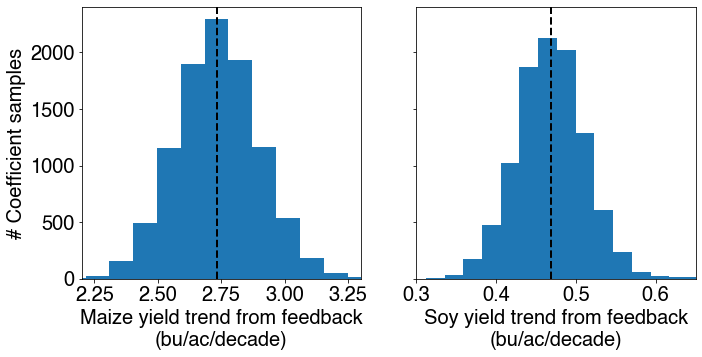

In [131]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(11,5))

maizeYieldFromFeedback_uncert_1d = np.reshape(maizeYieldFromFeedback, [maizeYieldFromFeedback.shape[0], maizeYieldFromFeedback.shape[1]*maizeYieldFromFeedback.shape[2]])
soybeanYieldFromFeedback_uncert_1d = np.reshape(soybeanYieldFromFeedback, [soybeanYieldFromFeedback.shape[0], soybeanYieldFromFeedback.shape[1]*soybeanYieldFromFeedback.shape[2]])

ax1.hist(np.nanmean(maizeYieldFromFeedback_uncert_1d, axis=0), bins=50)
ax1.set_ylim([0, 2400])
ax1.set_xlim([2.2, 3.3])
ax1.plot([np.nanmean(np.nanmean(maizeYieldFromFeedback_uncert_1d)), np.nanmean(np.nanmean(maizeYieldFromFeedback_uncert_1d))], [0, 2400], '--k', lw=2)
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)
ax1.set_xticks([2.25, 2.5, 2.75, 3.0, 3.25])
ax1.set_xlabel('Maize yield trend from feedback\n(bu/ac/decade)', fontsize=20)
ax1.set_ylabel('# Coefficient samples', fontsize=20)


ax2.set_xlim([0.3, 0.65])
ax2.set_ylim([0, 2400])
ax2.hist(np.nanmean(soybeanYieldFromFeedback_uncert_1d, axis=0), bins=25)
ax2.plot([np.nanmean(np.nanmean(soybeanYieldFromFeedback_uncert_1d)), np.nanmean(np.nanmean(soybeanYieldFromFeedback_uncert_1d))], [0, 2400], '--k', lw=2)
ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)
# ax2.set_xticks([.35, .45, .55])
ax2.set_xlabel('Soy yield trend from feedback\n(bu/ac/decade)', fontsize=20)
# ax2.set_ylabel('# Coefficient samples', fontsize=20)

plt.savefig('yield-trend-from-feedback-uncertainty-range.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.01)

In [97]:
plt.hist(mdl_LH_Y_CondNum)

NameError: name 'mdl_LH_Y_CondNum' is not defined

In [ ]:
scipy.stats.ks_2samp(maizeYieldFromFeedback_SSA, maizeYieldFromFeedback)

In [ ]:

plt.figure(figsize=(6,6))
plt.ylim([0,3.7])
plt.plot(areaLimit, np.nanmedian(maizeYieldFromFeedback_SensTest,axis=0), label='Maize')
plt.plot(areaLimit, np.nanmedian(soybeanYieldFromFeedback_SensTest,axis=0), label='Soy')
plt.plot([30,30],[0,3.7], '--k')
plt.xlabel('Minimum harvested fraction (%)',fontsize=20)
plt.ylabel('Median feedback yield effect\n(bu/ac/decade)', fontsize=20)
plt.xticks([10,20,30,40,50,60])
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
l1 = plt.legend(prop = {'size':20, 'family':'Helvetica'})
l1.get_frame().set_linewidth(0)
# plt.savefig('feedback-ha-sens-test.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.01)


In [34]:
# calculate mean yield, kdd, gdd, and trends across all counties to use for percent corrections in maps below
curCountyList = usCounties.copy()
useDeepak = False

countyAcAll = np.array([np.nanmean(a) for a in usCounties['maizeCountyArea']])
haMaizeAllAc = np.array([np.nanmean(a) for a in usCounties['maizeHarvestedArea']])
haSoybeanAllAc = np.array([np.nanmean(a) for a in usCounties['soybeanHarvestedArea']])
haTotalAllAc = haMaizeAllAc + haSoybeanAllAc
haAllFrac = np.array([np.nanmean(a) for a in usCounties['maizeHarvestedAreaFraction']])*100
irAggAll = np.array([a for a in usCounties['maizeCountyIrrigationFraction']])
kddTrendAll = np.array([a for a in usCounties['kddTrend']])*10
gddTrendAll = np.array([a for a in usCounties['gddTrend']])*10
prTrendAll = np.array([a for a in usCounties['seasonalPrecipTrend']])*10

countyAcAll = np.array([np.nanmean(a) for a in usCounties['maizeCountyArea']])
haMaizeMeanAllAc = np.array([np.nanmean(a) for a in usCounties['maizeHarvestedArea']])
haSoybeanMeanAllAc = np.array([np.nanmean(a) for a in usCounties['soybeanHarvestedArea']])
haTotalAllAc = haMaizeMeanAllAc + haSoybeanMeanAllAc
haTotalFracAll = haTotalAllAc/countyAcAll

meanPrAll = np.array([np.nanmean(a) for a in usCounties['seasonalPrecip']])

meanNetRadAll = np.array([np.nanmean(a) for a in usCounties['seasonalNetRad']])
meanSlhfAll = -np.array([np.nanmean(a) for a in usCounties['seasonalSlhf']])

if wxData == 'era5':
    countySeasonLenSec = np.array(list(curCountyList['seasonalSeconds']))
    meanNetRadAll /= countySeasonLenSec
    meanSlhfAll /= countySeasonLenSec

meanKddAll = np.array([np.nanmean(a) for a in usCounties['kdd']])
meanGddAll = np.array([np.nanmean(a) for a in usCounties['gdd']])

# convert slhf trend to w/m2/decade
slhfTrendAll = -np.array([a for a in usCounties['seasonalSlhfTrend']])
sshfTrendAll = -np.array([a for a in usCounties['seasonalSshfTrend']])
netRadTrendAll = np.array([a for a in usCounties['seasonalNetRadTrend']])

if wxData == 'era5':
    slhfTrendAll = [a*10/t for a,t in zip(slhfTrendAll, countySeasonLenSec)]
    sshfTrendAll = [a*10/t for a,t in zip(sshfTrendAll, countySeasonLenSec)]
    netRadTrendAll = [a*10/t for a,t in zip(netRadTrendAll, countySeasonLenSec)]

if useDeepak:
    yieldTrendAll = np.array([a for a in usCounties['maizeYieldTrendDeepak']])
    meanYieldAll = np.nanmean(np.array([a for a in usCounties['maizeYieldDeepak']]), axis=1)
    meanProdAll = meanYieldAll * haAllAc
else:
    maizeYieldTrendAll = np.array([a for a in usCounties['maizeYieldTrend']])*10
    maizeYieldAll = np.array([a for a in usCounties['maizeYield']])
    maizeYieldMeanAll = np.nanmean(np.array([a for a in usCounties['maizeYield']]), axis=1)
    
    soybeanYieldTrendAll = np.array([a for a in usCounties['soybeanYieldTrend']])*10
    soybeanYieldAll = np.array([a for a in usCounties['soybeanYield']])
    soybeanYieldStdAll = np.array([np.nanstd(a) for a in usCounties['soybeanYield']])
    soybeanYieldMeanAll = np.nanmean(np.array([a for a in usCounties['soybeanYield']]), axis=1)
    
    maizeYieldStdAll = np.full(maizeYieldTrendAll.shape, np.nan)
    soybeanYieldStdAll = np.full(maizeYieldTrendAll.shape, np.nan)
    for c in range(maizeYieldAll.shape[0]):
        nn = np.where(~np.isnan(maizeYieldAll[c,:]))[0]
        if np.nansum(maizeYieldAll[c,nn]) > 0:
            maizeYieldStdAll[c] = np.nanstd(scipy.signal.detrend(maizeYieldAll[c,nn]))
        
        nn = np.where(~np.isnan(soybeanYieldAll[c,:]))[0]
        if np.nansum(soybeanYieldAll[c,nn]) > 0:
            soybeanYieldStdAll[c] = np.nanstd(scipy.signal.detrend(soybeanYieldAll[c,nn]))
    
    countyMaizeHaAc = np.array([a for a in np.array(list(usCounties['maizeHarvestedArea']))])
    countySoybeanHaAc = np.array([a for a in np.array(list(usCounties['soybeanHarvestedArea']))])
    
    totalProdMeanAll = np.array([x[0]*np.nanmean(x[1]) for x in zip(maizeYieldMeanAll, countyMaizeHaAc)]) + np.array([x[0]*np.nanmean(x[1]) for x in zip(soybeanYieldMeanAll, countySoybeanHaAc)])
    maizeProdMeanAll = np.array([x[0]*np.nanmean(x[1]) for x in zip(maizeYieldMeanAll, countyMaizeHaAc)])
    totalProdMeanLast5All = np.full(totalProdMeanAll.shape, np.nan)
    totalProdTrendAll = np.full(totalProdMeanAll.shape, np.nan)
    totalProdOverTimeAll = np.full(maizeYieldAll.shape[1]-1, 0)
    totalHaTrendAll = np.full(totalProdMeanAll.shape, np.nan)
    for c in range(totalProdMeanAll.size):
        p_maize = np.array([x[0]*x[1] for x in zip(maizeYieldAll[c,:], countyMaizeHaAc[c,:])])
        p_soybean = np.array([x[0]*x[1] for x in zip(soybeanYieldAll[c,:], countySoybeanHaAc[c,:])])
        nn_maize = np.where(~np.isnan(p_maize))[0]
        nn_soybean = np.where(~np.isnan(p_soybean))[0]
        
        totalProdMeanLast5All[c] = np.nanmean(p_maize[nn_maize[-5:]]) + np.nanmean(p_soybean[nn_soybean[-5:]])
        
        for y in range(totalProdOverTimeAll.shape[0]):
            if ~np.isnan(p_maize[y]):
                totalProdOverTimeAll[y] += p_maize[y]
            if ~np.isnan(p_soybean[y]):
                totalProdOverTimeAll[y] += p_soybean[y]
        
        if len(nn_maize) >= 10:
            X =  sm.add_constant(range(len(nn_maize)))
            mdl = sm.OLS(p_maize[nn_maize],X).fit()
            totalProdTrendAll[c] = mdl.params[1]
            
            X =  sm.add_constant(range(len(nn_maize)))
            mdl = sm.OLS(countyMaizeHaAc[c,nn_maize],X).fit()
            totalHaTrendAll[c] = mdl.params[1]
        if len(nn_soybean) >= 10:
            X =  sm.add_constant(range(len(nn_soybean)))
            mdl = sm.OLS(p_soybean[nn_soybean],X).fit()
            if np.isnan(totalProdTrendAll[c]):
                totalProdTrendAll[c] = mdl.params[1]
            else:
                totalProdTrendAll[c] += mdl.params[1]
            
            X =  sm.add_constant(range(len(nn_soybean)))
            mdl = sm.OLS(countySoybeanHaAc[c, nn_soybean],X).fit()
            if np.isnan(totalProdTrendAll[c]):
                totalHaTrendAll[c] = mdl.params[1]
            else:
                totalHaTrendAll[c] += mdl.params[1]

nn = np.where((totalProdTrendAll > 0) & (~np.isnan(np.nanmedian(np.nanmedian(lhFromFeedback,axis=2), axis=1))) & (~np.isnan(haTotalFracAll)) & (mdl_LH_Y_PValues['TotalProd_DetrendAnom'] < 0.05))[0]
nnIr = np.where((totalProdTrendAll > 0) & (~np.isnan(np.nanmedian(np.nanmedian(lhFromFeedback,axis=2), axis=1))) & (~np.isnan(haTotalFracAll)) & (~np.isnan(irSel)) & (mdl_LH_Y_PValues['TotalProd_DetrendAnom'] < 0.05))[0]
nnNonIr = np.where((totalProdTrendAll > 0) & (~np.isnan(np.nanmedian(np.nanmedian(lhFromFeedback,axis=2), axis=1))) & (~np.isnan(haTotalFracAll)) & (np.isnan(irSel))& (mdl_LH_Y_PValues['TotalProd_DetrendAnom'] < 0.05))[0]
# noOutlierInd = np.where((abs(scipy.stats.zscore(lhFromFeedback[nn]/haTotalFracAll[nn])) < 1))[0]
adjNn = nn#[noOutlierInd]
# adjNnIr = np.intersect1d(adjNn, irSel)

Text(0, 0.5, 'Maize + soy production\n(billions of bushels)')

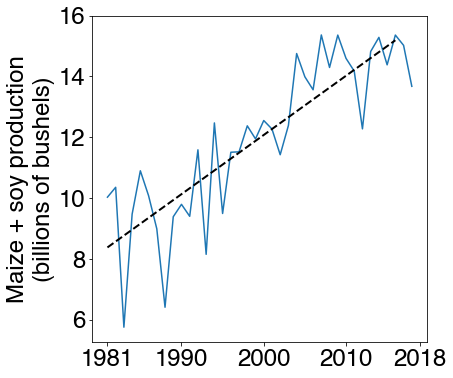

In [35]:
X = sm.add_constant(range(len(totalProdOverTimeAll)))
mdl = sm.OLS(totalProdOverTimeAll, X).fit()

x1 = 0
x2 = 35

plt.figure(figsize=(6,6))
plt.plot(totalProdOverTimeAll)
plt.plot([x1, x2], [mdl.params[0], mdl.params[0]+x2*mdl.params[1]], '--k', lw=2)
plt.xticks([0, 9, 19, 29, 38])
plt.gca().set_xticklabels([1981, 1990, 2000, 2010, 2018])

plt.yticks([.6e10, .8e10, 1e10, 1.2e10, 1.4e10, 1.6e10])
plt.gca().set_yticklabels([6, 8, 10, 12, 14, 16])

plt.tick_params(axis='x', labelsize=24)
plt.tick_params(axis='y', labelsize=24)

plt.ylabel('Maize + soy production\n(billions of bushels)', fontsize=24)
# plt.savefig('prod-growth-linear-trend.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.01)

In [36]:

# these are in w/m2 per million bu
print(np.nanmedian(mdl_LH_Y_Coefs['TotalProd_DetrendAnom'][nnNonIr]))
print(np.nanmedian(mdl_LH_Y_Coefs['TotalProd_DetrendAnom'][nnIr]))

0.6163505237309722
0.8709191023625436


In [37]:
len(nnIr)/len(adjNn)

0.14730878186968838

In [38]:
adjNn.shape

(353,)

In [39]:
# median prod coefficient value
np.nanmedian(mdl_LH_Y_Coefs['TotalProd_DetrendAnom'][adjNn])

0.6572094484461724

In [40]:
# median prod coefficient value in irrigated counties
np.nanmedian(mdl_LH_Y_Coefs['TotalProd_DetrendAnom'][nnIr])

0.8709191023625436

In [41]:
# fraction counties with positive signficant prod coefficient

nnSig = np.where((mdl_LH_Y_PValues['TotalProd_DetrendAnom'][adjNn]<0.05) & (mdl_LH_Y_Coefs['TotalProd_DetrendAnom'][adjNn]>0))[0]
len(nnSig)/len(adjNn)


1.0

In [42]:
# fraction of prod in counties w/ positive and sig. prod coefficient
np.nansum(totalProdMeanAll[adjNn[nnSig]])/np.nansum(totalProdMeanAll[adjNn])

1.0

In [43]:
# median lh r2 value

np.nanmedian(mdl_LH_Y_Coefs['R2'][adjNn])

0.7810823794586302

In [44]:
# number of included counties
len(adjNn)

353

In [45]:
# total maize/soy production in included counties
np.nansum(totalProdMeanAll[adjNn])/np.nansum(totalProdMeanAll)

0.5525519444153156

In [46]:
# % production occurring in counties with > 50% harvested area
indHa = np.where((haTotalAllAc[adjNn]/countyAcAll[adjNn]>.5))[0]
np.nansum(totalProdMeanAll[adjNn[indHa]])/np.nansum(totalProdMeanAll[adjNn])

0.7933007410896927

In [48]:
nn = np.where(~np.isnan(mdl_KDD_GDD_SoybeanYield_Coefs['KDD_Detrend']))[0]
ind = np.where(mdl_KDD_GDD_SoybeanYield_Coefs['KDD_Detrend'][nn]>0)[0]
len(ind)/len(mdl_KDD_GDD_SoybeanYield_Coefs['KDD_Detrend'][nn])

NameError: name 'mdl_KDD_GDD_SoybeanYield_Coefs' is not defined

In [ ]:
nn = np.where(~np.isnan(mdl_KDD_GDD_SoybeanYield_PValues['Pr_Detrend']))[0]
ind = np.where(mdl_KDD_GDD_SoybeanYield_PValues['Pr_Detrend'][nn]<0.05)[0]
len(ind)/len(mdl_KDD_GDD_SoybeanYield_PValues['Pr_Detrend'][nn])

In [ ]:
#     mdl_Param_Corr['Prod-Pr'][i] = np.corrcoef(dfProd['TotalProd_DetrendAnom'], dfProd['Pr_DetrendAnom'])[0,1]
#     mdl_Param_Corr['Prod-NetRad'][i] = np.corrcoef(dfProd['TotalProd_DetrendAnom'], dfProd['NetRad_DetrendAnom'])[0,1]
#     mdl_Param_Corr['Prod-Wind'][i] = np.corrcoef(dfProd['TotalProd_DetrendAnom'], dfProd['Wind_DetrendAnom'])[0,1]
#     mdl_Param_Corr['Pr-NetRad'][i] = np.corrcoef(dfProd['Pr_DetrendAnom'], dfProd['NetRad_DetrendAnom'])[0,1]
#     mdl_Param_Corr['Pr-Wind'][i] = np.corrcoef(dfProd['Pr_DetrendAnom'], dfProd['Wind_DetrendAnom'])[0,1]
#     mdl_Param_Corr['NetRad-Wind'][i] = np.corrcoef(dfProd['NetRad_DetrendAnom'], dfProd['Wind_DetrendAnom'])[0,1]
var='Prod-Wind'
nn = np.where(~np.isnan(mdl_Param_Corr[var]))[0]
plt.hist(mdl_Param_Corr[var][nn])
np.nanmedian(mdl_Param_Corr[var])
# scipy.stats.ttest_1samp(mdl_Param_Corr[var][nn], 0)

In [ ]:
(1-110/170)*450*2.26e6/np.nanmean(countySeasonLenSec)/NYears*10

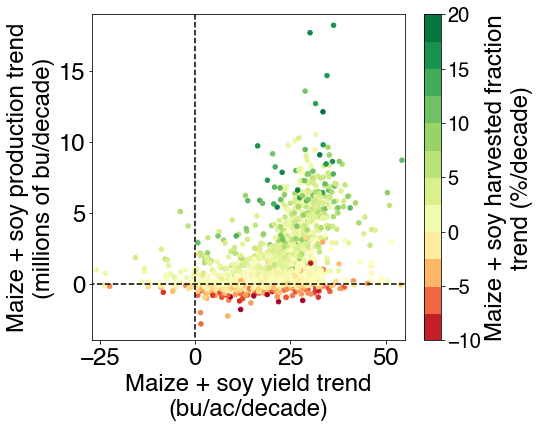

In [49]:
nn = np.where((~np.isnan(totalProdTrendAll)) & (~np.isnan(soybeanYieldTrendAll + maizeYieldTrendAll)) & (~np.isnan(totalHaTrendAll)))[0]

data = {'meanProd':totalProdMeanAll[nn], \
        'prodTrend':totalProdTrendAll[nn]/1e6*10, \
        'yieldTrend':soybeanYieldTrendAll[nn] + maizeYieldTrendAll[nn], \
        'haTrend':totalHaTrendAll[nn]/countyAcAll[nn]*100*10}
                        
df = pd.DataFrame(data, \
                  columns=['prodTrend', 'yieldTrend', 'haTrend'])
prodDriversMdl = smf.ols(formula='prodTrend ~ yieldTrend + haTrend', data=df).fit()
# prodDriversMdl.summary()

midnorm = MidpointNormalize(vmin=-10, vcenter=0, vmax=20)

# plt.scatter(data['haTrend'], data['prodTrend'])
fig = plt.figure(figsize=(7, 6))
plt.xlim([-27, 55])
plt.ylim([-4, 19])
a = plt.scatter(data['yieldTrend'], data['prodTrend'], c=data['haTrend'], cmap='RdYlGn', s = 20, norm=midnorm)
plt.plot([-30, 75], [0, 0], '--k')
plt.plot([0, 0], [-10, 20], '--k')

plt.xlabel('Maize + soy yield trend\n(bu/ac/decade)', fontsize=24)
plt.ylabel('Maize + soy production trend\n(millions of bu/decade)', fontsize=24)
plt.xticks([-25, 0, 25, 50])
plt.yticks([0, 5, 10, 15])
plt.tick_params(axis='x', labelsize=24)
plt.tick_params(axis='y', labelsize=24)

cbar = fig.colorbar(a, ax=plt.gca(),
                    ticks=np.arange(-10, 20.1, 5), boundaries=np.arange(-10, 20.1, 2.5))
cbar.set_label('Maize + soy harvested fraction\ntrend (%/decade)', fontsize=24)
cbar.ax.tick_params(labelsize=20)
# plt.savefig('us-prod-trend-vs-yield-trend-scatter-colorbar.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.01)
# plt.scatter(totalHaTrendAll, soybeanYieldTrendAll + maizeYieldTrendAll)
# plt.scatter(soybeanYieldTrendAll + maizeYieldTrendAll, totalProdTrendAll)

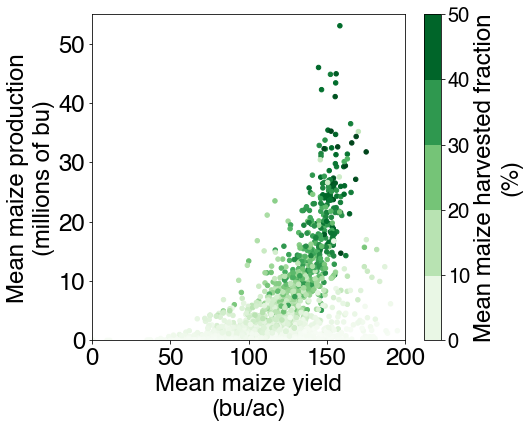

In [50]:
nn = np.where((~np.isnan(maizeProdMeanAll)) & (~np.isnan(maizeYieldMeanAll)) & (~np.isnan(np.nanmean(countyMaizeHaAc, axis=1))))[0]

data = {'meanMaizeProd':maizeProdMeanAll[nn]/1e6, \
        'meanMaizeYield':maizeYieldMeanAll[nn], \
        'meanMaizeHa':np.nanmean(countyMaizeHaAc[nn, :], axis=1)/countyAcAll[nn]*100}
                        
df = pd.DataFrame(data, \
                  columns=['meanMaizeProd', 'meanMaizeYield', 'meanMaizeHa'])
# prodDriversMdl = smf.ols(formula='prodTrend ~ yieldTrend + haTrend', data=df).fit()
# prodDriversMdl.summary()

v1 = 0
v2 = 50.1
vcenter = (v1+v2)/2

midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

# plt.scatter(data['haTrend'], data['prodTrend'])
fig = plt.figure(figsize=(7, 6))
plt.xlim([0, 200])
plt.ylim([0, 55])
a = plt.scatter(data['meanMaizeYield'], data['meanMaizeProd'], c=data['meanMaizeHa'], cmap='Greens', s = 20, norm=midnorm)
# plt.plot([0, 200], [0, 0], '--k')
# plt.plot([0, 0], [-10, 20], '--k')

plt.xlabel('Mean maize yield\n(bu/ac)', fontsize=24)
plt.ylabel('Mean maize production\n(millions of bu)', fontsize=24)
plt.xticks(np.arange(0, 201, 50))
plt.yticks(np.arange(0, 51, 10))
plt.tick_params(axis='x', labelsize=24)
plt.tick_params(axis='y', labelsize=24)

cbar = fig.colorbar(a, ax=plt.gca(),
                    ticks=np.arange(v1, v2, 10), boundaries=np.arange(v1, v2, 10))
cbar.set_label('Mean maize harvested fraction\n(%)', fontsize=24)
cbar.ax.tick_params(labelsize=20)
# plt.savefig('us-maize-prod-vs-yield-scatter-vs-ha-colorbar.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.01)
# plt.scatter(totalHaTrendAll, soybeanYieldTrendAll + maizeYieldTrendAll)
# plt.scatter(soybeanYieldTrendAll + maizeYieldTrendAll, totalProdTrendAll)

In [67]:

# production benefit from ag-int
# maizeYieldFromFeedback is in bu/ac/decade
maizeProdFromFeedback = np.reshape(np.nanmean(np.nanmean(maizeYieldFromFeedback, axis=2), axis=1), [maizeYieldFromFeedback.shape[0], 1]) * NYears/10 * haMaizeAllAc
soybeanProdFromFeedback = np.reshape(np.nanmean(np.nanmean(soybeanYieldFromFeedback, axis=2), axis=1), [soybeanYieldFromFeedback.shape[0], 1]) * NYears/10 * haSoybeanAllAc
print('maize from feedback (M bu): %.2f, (MT): %.2f'%((np.nansum(maizeProdFromFeedback[adjNn,:])/1e6), (np.nansum(maizeProdFromFeedback[adjNn,:])/1000)*.0254))
print('soy (M bu): %.2f, (MT): %.2f'%(np.nansum(soybeanProdFromFeedback[adjNn,:])/1e6, np.nansum(soybeanProdFromFeedback[adjNn,:])/1000*.0272155))#*27/1000/1000))

maize from feedback (M bu): 17283.82, (MT): 439009.06
soy (M bu): 2577.04, (MT): 70135.56


(2249, 39)

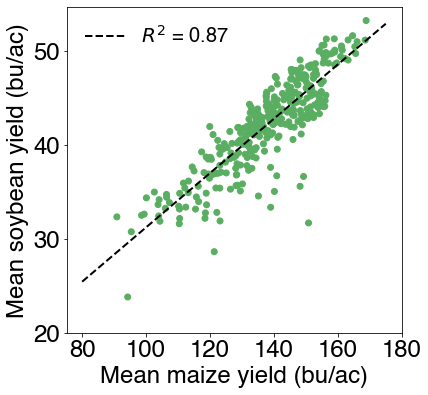

In [52]:
cmap = plt.cm.get_cmap('PRGn')
mmean = np.nanmean(countyMaizeYield,axis=1)
smean = np.nanmean(countySoybeanYield,axis=1)

# nn = np.where((~np.isnan(mmean)) & (~np.isnan(smean)))[0]

X = sm.add_constant(mmean[adjNn])
mdl = sm.OLS(smean[adjNn], X).fit()

x1 = 80
x2 = 175

plt.figure(figsize=(6,6))
plt.scatter(mmean[adjNn],smean[adjNn],c=[cmap(.8)]*len(adjNn))
plt.plot([x1, x2], mdl.params[0]+[x1*mdl.params[1], x2*mdl.params[1]], '--k', lw=2, label = '$R^2$ = 0.87')
plt.xlabel('Mean maize yield (bu/ac)', fontsize=24)
plt.xticks(np.arange(80, 181, 20))
plt.ylabel('Mean soybean yield (bu/ac)', fontsize=24)
plt.yticks([20, 30, 40, 50])
plt.tick_params(axis='x', labelsize=24)
plt.tick_params(axis='y', labelsize=24)
l1 = plt.legend(prop = {'size':20, 'family':'Helvetica'})
l1.get_frame().set_linewidth(0)
# plt.savefig('maize-soy-mean-yield-scatter.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

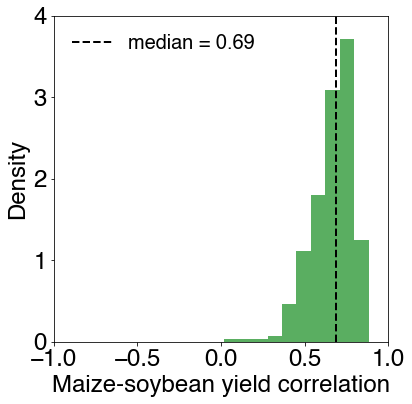

In [68]:
# correlation between maize and soy yields

mc = []
for c in range(countySoybeanYield.shape[0]):
    nn = np.where((~np.isnan(countySoybeanYield[c,:])) & (~np.isnan(countyMaizeYield[c,:])))[0]
    if len(nn) > 0:
        soybeanYieldDt = scipy.signal.detrend(countySoybeanYield[c, nn])
        maizeYieldDt = scipy.signal.detrend(countyMaizeYield[c,nn])
        mc.append(np.corrcoef(soybeanYieldDt, maizeYieldDt)[0,1])
    else:
        mc.append(np.nan)
mc = np.array(mc)
plt.figure(figsize=(6,6))
plt.ylim([0,4])
plt.hist(mc[adjNn], density=True, facecolor=cmap(.8), bins=10)
plt.plot([np.nanmedian(mc[adjNn]), np.nanmedian(mc[adjNn])], [0, 4], '--k', lw=2, label='median = %.2f'%np.nanmedian(mc[adjNn]))
plt.xlabel('Maize-soybean yield correlation', fontsize=24)
plt.ylabel('Density', fontsize=24)
plt.xticks(np.arange(-1, 1.1, .5))
# plt.yticks([20, 30, 40, 50])
plt.tick_params(axis='x', labelsize=24)
plt.tick_params(axis='y', labelsize=24)
l1 = plt.legend(prop = {'size':20, 'family':'Helvetica'})
l1.get_frame().set_linewidth(0)
# plt.savefig('maize-soy-yield-corr.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

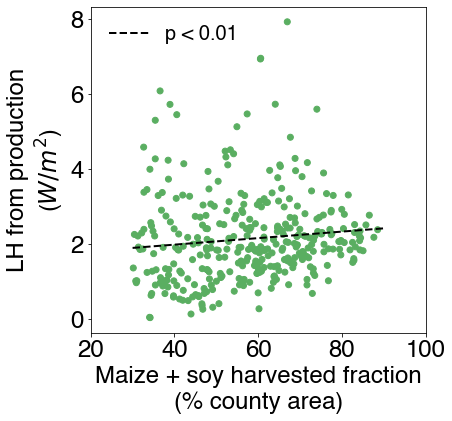

In [72]:
cmap = plt.cm.get_cmap('PRGn')

haFrac = haTotalAllAc/countyAcAll*100

# nn = np.where((~np.isnan(haFrac)) & (haFrac > 20) & (~np.isnan(mdl_LH_Y_Coefs['TotalProd_DetrendAnom'])))[0]

# print('frac < 20%% ha: %.2f'%(len(np.where(haFrac[]<20)[0])/len(nn)))

X = sm.add_constant(haFrac[adjNn])
mdl = sm.OLS(np.nanmean(np.nanmean(lhFromFeedback[adjNn, :, :], axis=2), axis=1), X).fit()

x1 = 30
x2 = 90

plt.figure(figsize=(6,6))
# plt.xlim([-.1,55])
# plt.ylim([-.1,4.5])
plt.scatter(haFrac[adjNn], np.nanmean(np.nanmean(lhFromFeedback[adjNn, :, :], axis=2), axis=1), c = [cmap(.8)]*len(adjNn))
plt.plot([x1, x2], mdl.params[0]+[x1*mdl.params[1], x2*mdl.params[1]], '--k', lw=2, label = 'p < 0.01')
plt.xlabel('Maize + soy harvested fraction\n(% county area)', fontsize=24)
plt.xticks(np.arange(20, 101, 20))
plt.ylabel('LH from production\n($W/m^2$)', fontsize=24)
plt.tick_params(axis='x', labelsize=24)
plt.tick_params(axis='y', labelsize=24)
l1 = plt.legend(prop = {'size':20, 'family':'Helvetica'})
l1.get_frame().set_linewidth(0)
# plt.savefig('lh-from-prod-vs-harvested-frac.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

In [ ]:
cmap = plt.cm.get_cmap('PRGn')

haFrac = haTotalAllAc/countyAcAll*100

# nn = np.where((~np.isnan(haFrac)) & (haFrac > 20) & (~np.isnan(mdl_LH_Y_Coefs['TotalProd_DetrendAnom'])))[0]

# print('frac < 20%% ha: %.2f'%(len(np.where(haFrac[]<20)[0])/len(nn)))

X = sm.add_constant(haFrac[adjNn])
mdl = sm.OLS(mdl_LH_Y_PValues['TotalProd_DetrendAnom'][adjNn], X).fit()

x1 = 10
x2 = 90

plt.figure(figsize=(6,6))
# plt.xlim([-.1,55])
# plt.ylim([0,.06])
plt.scatter(haFrac[adjNn], mdl_LH_Y_PValues['TotalProd_DetrendAnom'][adjNn], c = [cmap(.8)]*len(adjNn))
plt.plot([x1, x2], mdl.params[0]+[x1*mdl.params[1], x2*mdl.params[1]], '--k', lw=2, label = 'p < 0.01')
plt.xlabel('Maize + soy harvested fraction\n(% county area)', fontsize=24)
plt.xticks(np.arange(0, 101, 20))
plt.ylabel('$\\beta_{Production}$ p-value', fontsize=24)
plt.tick_params(axis='x', labelsize=24)
plt.tick_params(axis='y', labelsize=24)
l1 = plt.legend(prop = {'size':20, 'family':'Helvetica'})
l1.get_frame().set_linewidth(0)
# plt.savefig('beta-prod-pval-vs-harvested-frac.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

In [ ]:
# this enables legends for text objects to show the significance markers
import string
from matplotlib.legend_handler import HandlerBase
from matplotlib.text import Text, Annotation
from matplotlib.legend import Legend
class TextHandlerA(HandlerBase):
    def create_artists(self, legend, artist ,xdescent, ydescent,
                        width, height, fontsize, trans):
        tx = Text(width/2.,height/2, artist.get_text(), fontsize=fontsize,
                  ha="center", va="center", fontweight="bold")
        return [tx]

Legend.update_default_handler_map({Text : TextHandlerA()})



width = .5
cmap = plt.cm.get_cmap('PRGn')

plt.figure(figsize=(6,2))
plt.xlim([.5,4.5])
if wxData == 'era5':
    plt.ylim([-.1,1.5])
elif wxData == 'gldas':
    plt.ylim([-.1,1.8])

l1_TotalProd = np.nanpercentile(mdl_LH_Y_Norm_Coefs['TotalProd_DetrendAnom_Norm'][adjNn],10)
l2_TotalProd = np.nanpercentile(mdl_LH_Y_Norm_Coefs['TotalProd_DetrendAnom_Norm'][adjNn],90)
ind_TotalProd = np.where((mdl_LH_Y_Norm_Coefs['TotalProd_DetrendAnom_Norm']>l1_TotalProd) & (mdl_LH_Y_Norm_Coefs['TotalProd_DetrendAnom_Norm']<l2_TotalProd))[0]

xvalues = [1,2,3,4]
yvalues = [np.nanmedian(mdl_LH_Y_Norm_Coefs['TotalProd_DetrendAnom_Norm'][ind_TotalProd]), 
           np.nanmedian(mdl_LH_Y_Norm_Coefs['Pr_DetrendAnom_Norm'][ind_TotalProd]),
           np.nanmedian(mdl_LH_Y_Norm_Coefs['NetRad_DetrendAnom_Norm'][ind_TotalProd]),
           np.nanmedian(mdl_LH_Y_Norm_Coefs['Wind_DetrendAnom_Norm'][ind_TotalProd])]
pvalues = [len(np.where(mdl_LH_Y_Norm_PValues['TotalProd_DetrendAnom_Norm']<0.05)[0])/len(adjNn), 
           len(np.where(mdl_LH_Y_Norm_PValues['Pr_DetrendAnom_Norm']<0.05)[0])/len(adjNn),
           len(np.where(mdl_LH_Y_Norm_PValues['NetRad_DetrendAnom_Norm']<0.05)[0])/len(adjNn),
           len(np.where(mdl_LH_Y_Norm_PValues['Wind_DetrendAnom_Norm']<0.05)[0])/len(adjNn)]
yerrs = [np.nanstd(mdl_LH_Y_Norm_Coefs['TotalProd_DetrendAnom_Norm'][ind_TotalProd]),
         np.nanstd(mdl_LH_Y_Norm_Coefs['Pr_DetrendAnom_Norm'][ind_TotalProd]),
         np.nanstd(mdl_LH_Y_Norm_Coefs['NetRad_DetrendAnom_Norm'][ind_TotalProd]),
         np.nanstd(mdl_LH_Y_Norm_Coefs['Wind_DetrendAnom_Norm'][ind_TotalProd])]

facecolors = [cmap(.8), '#aaaaaa', '#aaaaaa', '#aaaaaa']
b = plt.bar(xvalues, yvalues, width=width, yerr=yerrs, capsize=3, error_kw={'lw':1})
plt.plot([.5, 5.5], [0,0], '-k', lw=1)
plt.xticks([1,2,3,4], rotation=45, fontsize=20)
if wxData == 'era5':
    plt.yticks([0, .5, 1], fontsize=20)
elif wxData == 'gldas':
    plt.yticks([0, .5, 1, 1.5], fontsize=20)
plt.gca().set_xticklabels(['Prod', 'Pr', '$R_{net}$', 'Wind'], fontsize=20)
plt.ylabel('National\nmedian\nstandardized\ncoefficient', fontsize=20)

plt.title('$LH \sim Prod_{maize+soybean} + Pr + R_{net} + Wind$', fontsize=18)

if wxData == 'era5':
    plt.text(.75, .75, '$R^2$ = %0.2f'%(np.nanmedian(mdl_LH_Y_Coefs['R2'][ind_TotalProd])), fontdict = {'size':16, 'family':'Helvetica'})
elif wxData == 'gldas':
    plt.text(.75, .75, '$R^2$ = %0.2f'%(np.nanmedian(mdl_LH_Y_Coefs['R2'][ind_TotalProd])), fontdict = {'size':16, 'family':'Helvetica'})

i = 0
k = 0
errBarLC = b.errorbar.lines[2][0]
for pat, errline, yval, pval, c in zip(b.patches, errBarLC.get_segments(), yvalues, pvalues, facecolors):
    pat.set_facecolor(c)
    
    xpos = errline[0][0]
    if yval >= 0:
        ypos = errline[1][1]
    else:
        ypos = errline[0][1]*1.23
    
    if pval > .75:
        if i == 0:
            t = plt.text(xpos, ypos, '***', ha='center')
        else:
            plt.text(xpos, ypos, '***', ha='center')
        i += 1
    elif pval > .5:
        if k == 0:
            t2 = plt.text(xpos, ypos, '*', ha='center')
        k += 1

if wxData == 'era5':
    leg = plt.legend([t], ['75% significant'], prop = {'size':16, 'family':'Helvetica'}, loc = 'upper left')
elif wxData == 'gldas':
    leg = plt.legend([t], ['75% significant'], prop = {'size':16, 'family':'Helvetica'}, loc = 'upper left')
leg.get_frame().set_linewidth(0.0)
# plt.savefig('reg-coef-lh-yield-nass-%s.eps'%wxData, format='eps', dpi=500, bbox_inches = 'tight', pad_inches = 0)

In [ ]:
width=.5
cmap = plt.cm.get_cmap('PRGn')

plt.figure(figsize=(3,2))
plt.xlim([.5,2.5])
plt.ylim([-4,4])

xvalues = [1,2]
yvalues = [np.nanmedian(mdl_LH_SH_Norm_Coefs['SLHF_DetrendAnom_Norm'][adjNn]), 
           np.nanmedian(mdl_LH_SH_Norm_Coefs['NetRad_DetrendAnom_Norm'][adjNn])]
pvalues = [len(np.where(mdl_LH_SH_Norm_PValues['SLHF_DetrendAnom_Norm'][adjNn]<0.05)[0])/len(adjNn), 
           len(np.where(mdl_LH_SH_Norm_PValues['NetRad_DetrendAnom_Norm'][adjNn]<0.05)[0])/len(adjNn)]
yerrs = [np.nanstd(mdl_LH_SH_Norm_Coefs['SLHF_DetrendAnom_Norm'][adjNn]),
         np.nanstd(mdl_LH_SH_Norm_Coefs['NetRad_DetrendAnom_Norm'][adjNn])]
facecolors = [cmap(.8), '#aaaaaa', '#aaaaaa', '#aaaaaa', '#aaaaaa']
b = plt.bar(xvalues, yvalues, width=width, yerr=yerrs, capsize=3, error_kw={'lw':1})
plt.plot([.5, 2.5], [0,0], '-k', lw=1)
plt.xticks([1,2], rotation=45, fontsize=20)
plt.yticks([-4, -2, 0, 2, 4], fontsize=20)
plt.gca().set_xticklabels(['LH', '$R_{net}$'], fontsize=20)
plt.ylabel('National\nmedian\nstandardized\ncoefficient', fontsize=20)

plt.title('$SH \sim LH + R_{net}$', fontsize=18)

plt.text(.7, 2, '$R^2$ = %0.2f'%(np.nanmedian(mdl_LH_SH_Coefs['R2'][adjNn])), fontdict = {'size':16, 'family':'Helvetica'})

errBarLC = b.errorbar.lines[2][0]
for pat, errline, yval, pval, c in zip(b.patches, errBarLC.get_segments(), yvalues, pvalues, facecolors):
    pat.set_facecolor(c)
    
    xpos = errline[0][0]
    if yval >= 0:
        ypos = errline[1][1]
    else:
        ypos = errline[0][1]*1.35
    
    if pval > .8:
        plt.text(xpos, ypos, '***', ha='center')
#     elif pval < .05:
#         plt.text(xpos, ypos, '**', ha='center')
#     elif pval < .1:
#         plt.text(xpos, ypos, '*', ha='center')

# plt.savefig('reg-coef-lh-sh-nass-%s.eps'%wxData, format='eps', dpi=500, bbox_inches = 'tight', pad_inches = 0)

In [ ]:
width=.5
cmap = plt.cm.get_cmap('PRGn')

plt.figure(figsize=(3,2))
plt.xlim([.5,2.5])
plt.ylim([0,2.1])

xvalues = [.85,1.85]
yvalues = [np.nanmedian(mdl_SH_KDD_Norm_Coefs['SSHF_DetrendAnom_Norm'][adjNn]), 
           np.nanmedian(mdl_SH_GDD_Norm_Coefs['SSHF_DetrendAnom_Norm'][adjNn])]
pvalues = [len(np.where(mdl_SH_KDD_Norm_PValues['SSHF_DetrendAnom_Norm'][adjNn]<0.05)[0])/len(adjNn), 
           len(np.where(mdl_SH_GDD_Norm_PValues['SSHF_DetrendAnom_Norm'][adjNn]<0.05)[0])/len(adjNn)]
yerrs = [np.nanstd(mdl_SH_KDD_Norm_Coefs['SSHF_DetrendAnom_Norm'][adjNn]),
         np.nanstd(mdl_SH_GDD_Norm_Coefs['SSHF_DetrendAnom_Norm'][adjNn])]
facecolors = [cmap(.8), cmap(.8)]
b = plt.bar(xvalues, yvalues, width=width, yerr=yerrs, capsize=3, error_kw={'lw':1})
plt.plot([.5, 2.5], [0,0], '-k', lw=1)
plt.xticks([.85,1.85], rotation=45, fontsize=20)
plt.yticks([0, 1, 2], fontsize=20)
plt.gca().set_xticklabels(['KDD', 'GDD'], fontsize=20)
plt.ylabel('National\nmedian\nstandardized\ncoefficient', fontsize=20)

plt.title('$KDD \sim SH$\n$GDD \sim SH$', fontsize=18)

plt.text(1.15, 1.5, 'KDD $R^2$ = %0.2f'%(np.nanmedian(mdl_SH_KDD_Coefs['R2'][adjNn])), fontdict = {'size':16, 'family':'Helvetica'})
plt.text(1.15, 1.1, 'GDD $R^2$ = %0.2f'%(np.nanmedian(mdl_SH_GDD_Coefs['R2'][adjNn])), fontdict = {'size':16, 'family':'Helvetica'})

errBarLC = b.errorbar.lines[2][0]
for pat, errline, yval, pval, c in zip(b.patches, errBarLC.get_segments(), yvalues, pvalues, facecolors):
    pat.set_facecolor(c)
    
    xpos = errline[0][0]
    if yval >= 0:
        ypos = errline[1][1]
    else:
        ypos = errline[0][1]*1.23
    
    if pval > .8:
        plt.text(xpos, ypos, '***', ha='center')
#     elif pval < .05:
#         plt.text(xpos, ypos, '**', ha='center')
#     elif pval < .1:
#         plt.text(xpos, ypos, '*', ha='center')

# plt.savefig('reg-coef-sh-kdd-gdd-nass-%s.eps'%wxData, format='eps', dpi=500, bbox_inches = 'tight', pad_inches = 0)

In [ ]:
width=.5
cmap = plt.cm.get_cmap('PRGn')

plt.figure(figsize=(4,2))
plt.xlim([.5,3.5])
plt.ylim([-1.3,2])

xvalues = [1,2,3]
yvalues = [np.nanmedian(mdl_KDD_GDD_MaizeYield_Norm_Coefs['KDD_DetrendNorm'][adjNn]), 
           np.nanmedian(mdl_KDD_GDD_MaizeYield_Norm_Coefs['GDD_DetrendNorm'][adjNn]),
           np.nanmedian(mdl_KDD_GDD_MaizeYield_Norm_Coefs['Pr_DetrendNorm'][adjNn])]
pvalues = [len(np.where(mdl_KDD_GDD_MaizeYield_Norm_PValues['KDD_DetrendNorm'][adjNn]<0.05)[0])/len(adjNn), 
           len(np.where(mdl_KDD_GDD_MaizeYield_Norm_PValues['GDD_DetrendNorm'][adjNn]<0.05)[0])/len(adjNn),
           len(np.where(mdl_KDD_GDD_MaizeYield_Norm_PValues['Pr_DetrendNorm'][adjNn]<0.05)[0])/len(adjNn)]
yerrs = [np.nanstd(mdl_KDD_GDD_MaizeYield_Norm_Coefs['KDD_DetrendNorm'][adjNn]), 
         np.nanstd(mdl_KDD_GDD_MaizeYield_Norm_Coefs['GDD_DetrendNorm'][adjNn]),
         np.nanstd(mdl_KDD_GDD_MaizeYield_Norm_Coefs['Pr_DetrendNorm'][adjNn])]
facecolors = [cmap(.8), cmap(.8), '#aaaaaa']
b = plt.bar(xvalues, yvalues, width=width, yerr=yerrs, capsize=3, error_kw={'lw':1})
plt.plot([.5, 3.5], [0,0], '-k', lw=1)
plt.xticks([1,2,3], rotation=45, fontsize=20)
plt.yticks([-1, 0, 1], fontsize=20)
plt.gca().set_xticklabels(['KDD', 'GDD', 'Pr'], fontsize=20)
plt.ylabel('National\nmedian\nstandardized\ncoefficient', fontsize=20)

plt.title('$Yield_{maize} \sim KDD + GDD + Pr$', fontsize=18)

plt.text(.7, 1.2, '$R^2$ = %0.2f'%(np.nanmedian(mdl_KDD_GDD_MaizeYield_Coefs['R2'][adjNn])), fontdict = {'size':16, 'family':'Helvetica'})

errBarLC = b.errorbar.lines[2][0]
for pat, errline, yval, pval, c in zip(b.patches, errBarLC.get_segments(), yvalues, pvalues, facecolors):
    pat.set_facecolor(c)
    
    xpos = errline[0][0]
    if yval >= 0:
        ypos = errline[1][1]
    else:
        ypos = errline[0][1]*1.325
    
    if pval > .8:
        plt.text(xpos, ypos, '***', ha='center')
#     elif pval < .05:
#         plt.text(xpos, ypos, '**', ha='center')
#     elif pval < .1:
#         plt.text(xpos, ypos, '*', ha='center')

# plt.savefig('reg-coef-yield-maize-kdd-gdd-pr-nass-%s.eps'%wxData, format='eps', dpi=500, bbox_inches = 'tight', pad_inches = 0)

In [ ]:
width=.5
cmap = plt.cm.get_cmap('PRGn')

plt.figure(figsize=(4,2))
plt.xlim([.5,3.5])
plt.ylim([-1.5,2.8])

xvalues = [1,2,3]
yvalues = [np.nanmedian(mdl_KDD_GDD_SoybeanYield_Norm_Coefs['KDD_DetrendNorm'][adjNn]), 
           np.nanmedian(mdl_KDD_GDD_SoybeanYield_Norm_Coefs['GDD_DetrendNorm'][adjNn]),
           np.nanmedian(mdl_KDD_GDD_SoybeanYield_Norm_Coefs['Pr_DetrendNorm'][adjNn])]
pvalues = [len(np.where(mdl_KDD_GDD_SoybeanYield_Norm_PValues['KDD_DetrendNorm'][adjNn]<0.05)[0])/len(adjNn), 
           len(np.where(mdl_KDD_GDD_SoybeanYield_Norm_PValues['GDD_DetrendNorm'][adjNn]<0.05)[0])/len(adjNn),
           len(np.where(mdl_KDD_GDD_SoybeanYield_Norm_PValues['Pr_DetrendNorm'][adjNn]<0.05)[0])/len(adjNn)]
yerrs = [np.nanstd(mdl_KDD_GDD_SoybeanYield_Norm_Coefs['KDD_DetrendNorm'][adjNn]), 
         np.nanstd(mdl_KDD_GDD_SoybeanYield_Norm_Coefs['GDD_DetrendNorm'][adjNn]),
         np.nanstd(mdl_KDD_GDD_SoybeanYield_Norm_Coefs['Pr_DetrendNorm'][adjNn])]
facecolors = [cmap(.8), cmap(.8), '#aaaaaa']
b = plt.bar(xvalues, yvalues, width=width, yerr=yerrs, capsize=3, error_kw={'lw':1})
plt.plot([.5, 3.5], [0,0], '-k', lw=1)
plt.xticks([1,2,3], rotation=45, fontsize=20)
plt.yticks([-1, 0, 1, 2], fontsize=20)
plt.gca().set_xticklabels(['KDD', 'GDD', 'Pr'], fontsize=20)
plt.ylabel('National\nmedian\nstandardized\ncoefficient', fontsize=20)

plt.title('$Yield_{soybean} \sim KDD + GDD + Pr$', fontsize=18)

plt.text(.7, 1.5, '$R^2$ = %0.2f'%(np.nanmedian(mdl_KDD_GDD_SoybeanYield_Coefs['R2'][adjNn])), fontdict = {'size':16, 'family':'Helvetica'})

errBarLC = b.errorbar.lines[2][0]
for pat, errline, yval, pval, c in zip(b.patches, errBarLC.get_segments(), yvalues, pvalues, facecolors):
    pat.set_facecolor(c)
    
    xpos = errline[0][0]
    if yval >= 0:
        ypos = errline[1][1]
    else:
        ypos = errline[0][1]*1.55
    
    if pval > .8:
        plt.text(xpos, ypos, '***', ha='center')
#     elif pval < .05:
#         plt.text(xpos, ypos, '**', ha='center')
#     elif pval < .1:
#         plt.text(xpos, ypos, '*', ha='center')

# plt.savefig('reg-coef-soybean-yield-kdd-gdd-pr-nass-%s.eps'%wxData, format='eps', dpi=500, bbox_inches = 'tight', pad_inches = 0)

In [ ]:
np.matlib.repmat(np.nanmean(countyMaizeYield[nnAgInt], axis=1), 91, 1).T

In [ ]:
maizeYieldChgAgInt = (maizeYieldChgFeedbackWithAgInt[nnAgInt, :]*NYears/10) / \
                        np.matlib.repmat(np.nanmean(countyMaizeYield[nnAgInt], axis=1), maizeYieldChgFeedbackWithAgInt.shape[1], 1).T*100
maizeYieldChgNoAgInt = (maizeYieldChgFeedbackWithoutAgInt[nnNoAgInt, :]*NYears/10) / \
                        np.matlib.repmat(np.nanmean(countyMaizeYield[nnNoAgInt], axis=1), maizeYieldChgFeedbackWithoutAgInt.shape[1], 1).T*100

maizeYieldChgAgInt = np.reshape(maizeYieldChgAgInt, [maizeYieldChgAgInt.size, 1])
maizeYieldChgNoAgInt = np.reshape(maizeYieldChgNoAgInt, [maizeYieldChgNoAgInt.size, 1])

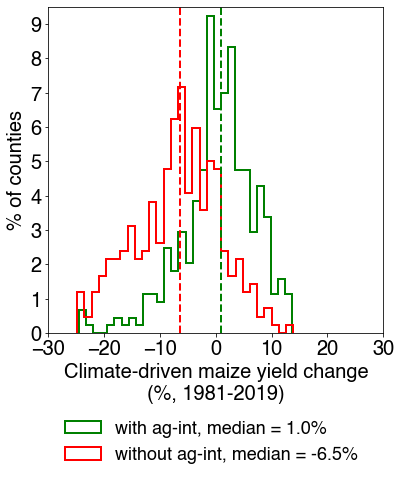

In [81]:
from scipy.stats import norm

# convert these trends back to changes over the time period
nnAgInt = adjNn[np.where(~np.isnan((maizeYieldChgFeedbackWithAgInt[adjNn,0,0]*NYears/10)/np.nanmean(countyMaizeYield[adjNn], axis=1)*100))[0]]
nnNoAgInt = adjNn[np.where(~np.isnan((maizeYieldChgFeedbackWithoutAgInt[adjNn,0,0]*NYears/10)/np.nanmean(countyMaizeYield[adjNn], axis=1)*100))[0]]

maizeYieldChgAgInt = (np.nanmean(np.nanmean(maizeYieldChgFeedbackWithAgInt[nnAgInt, :, :], axis=2), axis=1)*NYears/10)/np.nanmean(countyMaizeYield[nnAgInt], axis=1)*100
maizeYieldChgNoAgInt = (np.nanmean(np.nanmean(maizeYieldChgFeedbackWithoutAgInt[nnNoAgInt, :, :], axis=2), axis=1)*NYears/10)/np.nanmean(countyMaizeYield[nnNoAgInt], axis=1)*100

maizeYieldChgAgInt = maizeYieldChgAgInt[abs(maizeYieldChgAgInt)<25]
maizeYieldChgNoAgInt = maizeYieldChgNoAgInt[abs(maizeYieldChgNoAgInt)<25]

plt.figure(figsize=(6,6))

plt.xlim([-25, 25])
if wxData == 'era5':
    plt.ylim([0, 0.095])
elif wxData == 'gldas':
    plt.ylim([0, 0.1])

histAgIntN, histAgIntBins, histAgIntPatches = plt.hist(maizeYieldChgAgInt, bins=30, density=True, histtype='step', color='g', lw=2, \
                                                       label='with ag-int, median = %0.1f%%'%np.nanmedian(maizeYieldChgAgInt))

histNoAgIntN, histNoAgIntBins, histNoAgIntPatches = plt.hist(maizeYieldChgNoAgInt, bins=30, density=True, histtype='step', color='r', lw=2, \
                                                             label='without ag-int, median = %0.1f%%'%np.nanmedian(maizeYieldChgNoAgInt))
if wxData == 'era5':
#     plt.plot([0,0], [0,0.09], '-k', lw=2)
    plt.plot([np.nanmedian(maizeYieldChgAgInt),np.nanmedian(maizeYieldChgAgInt)], [0,0.095], '--g', lw=2)
    plt.plot([np.nanmedian(maizeYieldChgNoAgInt),np.nanmedian(maizeYieldChgNoAgInt)], [0,0.095], '--r', lw=2)
elif wxData == 'gldas':
    plt.plot([0,0], [0,0.1], '-k', lw=2)
    plt.plot([np.nanmedian(maizeYieldChgAgInt),np.nanmedian(maizeYieldChgAgInt)], [0,0.1], '--g', lw=2)
    plt.plot([np.nanmedian(maizeYieldChgNoAgInt),np.nanmedian(maizeYieldChgNoAgInt)], [0,0.1], '--r', lw=2)
    
plt.xlabel('Climate-driven maize yield change\n(%, 1981-2019)', fontsize=20)
plt.ylabel('% of counties', fontsize=20)

if wxData == 'era5':
    plt.yticks([0, .01, .02, .03, .04, .05, .06, .07, .08, .09], fontsize=20)
    plt.gca().set_yticklabels([0,1,2,3,4,5,6,7, 8, 9], fontsize=20)
elif wxData == 'gldas':
    plt.yticks([0, .01, .02, .03, .04, .05, .06, .07, .08, .09, .1], fontsize=20)
    plt.gca().set_yticklabels([0,1,2,3,4,5,6,7,8,9,10], fontsize=20)
    
plt.xticks([-30, -20, -10, 0, 10, 20, 30], fontsize=20)

leg = plt.legend(prop = {'size':18, 'family':'Helvetica'}, loc = 'lower left', bbox_to_anchor=(0, -.45))
leg.get_frame().set_linewidth(0.0)

# if useDeepak:
#     plt.savefig('maize-yield-chg-with-and-without-feedback-deepak-%s.png'%wxData, format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.01)
# else:
#     plt.savefig('maize-yield-chg-with-and-without-feedback-nass-%s.png'%wxData, format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.01)

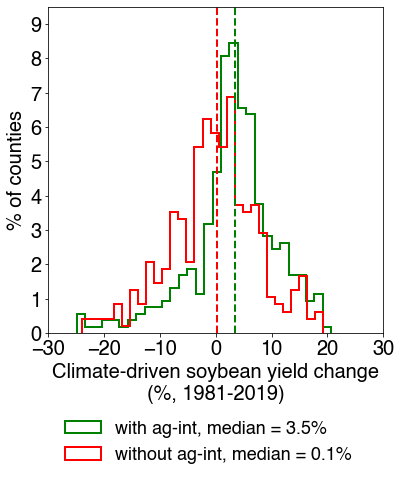

In [82]:
from scipy.stats import norm

# convert these trends back to changes over the time period
nnAgInt = adjNn[np.where(~np.isnan((soybeanYieldChgFeedbackWithAgInt[adjNn, 0, 0]*NYears/10)/np.nanmean(countySoybeanYield[adjNn], axis=1)*100))[0]]
nnNoAgInt = adjNn[np.where(~np.isnan((soybeanYieldChgFeedbackWithoutAgInt[adjNn, 0, 0]*NYears/10)/np.nanmean(countySoybeanYield[adjNn], axis=1)*100))[0]]

soybeanYieldChgAgInt = (np.nanmean(np.nanmean(soybeanYieldChgFeedbackWithAgInt[nnAgInt, :, :], axis=2), axis=1)*NYears/10)/np.nanmean(countySoybeanYield[nnAgInt], axis=1)*100
soybeanYieldChgNoAgInt = (np.nanmean(np.nanmean(soybeanYieldChgFeedbackWithoutAgInt[nnNoAgInt, :, :], axis=2), axis=1)*NYears/10)/np.nanmean(countySoybeanYield[nnNoAgInt], axis=1)*100

soybeanYieldChgAgInt = soybeanYieldChgAgInt[abs(soybeanYieldChgAgInt)<25]
soybeanYieldChgNoAgInt = soybeanYieldChgNoAgInt[abs(soybeanYieldChgNoAgInt)<25]

plt.figure(figsize=(6,6))

plt.xlim([-25, 25])
if wxData == 'era5':
    plt.ylim([0, 0.095])
elif wxData == 'gldas':
    plt.ylim([0, 0.095])

histAgIntN, histAgIntBins, histAgIntPatches = plt.hist(soybeanYieldChgAgInt, bins=30, density=True, histtype='step', color='g', lw=2, \
                                                       label='with ag-int, median = %0.1f%%'%np.nanmedian(soybeanYieldChgAgInt))

histNoAgIntN, histNoAgIntBins, histNoAgIntPatches = plt.hist(soybeanYieldChgNoAgInt, bins=30, density=True, histtype='step', color='r', lw=2, \
                                                             label='without ag-int, median = %0.1f%%'%np.nanmedian(soybeanYieldChgNoAgInt))

if wxData == 'era5':
#     plt.plot([0,0], [0,0.09], '-k', lw=2)
    plt.plot([np.nanmedian(soybeanYieldChgAgInt),np.nanmedian(soybeanYieldChgAgInt)], [0,0.095], '--g', lw=2)
    plt.plot([np.nanmedian(soybeanYieldChgNoAgInt),np.nanmedian(soybeanYieldChgNoAgInt)], [0,0.095], '--r', lw=2)
elif wxData == 'gldas':
    plt.plot([0,0], [0,0.1], '-k', lw=2)
    plt.plot([np.nanmedian(soybeanYieldChgAgInt),np.nanmedian(soybeanYieldChgAgInt)], [0,0.1], '--g', lw=2)
    plt.plot([np.nanmedian(soybeanYieldChgNoAgInt),np.nanmedian(soybeanYieldChgNoAgInt)], [0,0.1], '--r', lw=2)
\
plt.xlabel('Climate-driven soybean yield change\n(%, 1981-2019)', fontsize=20)
plt.ylabel('% of counties', fontsize=20)
if wxData == 'era5':
    plt.yticks([0, .01, .02, .03, .04, .05, .06, .07, .08, .09], fontsize=20)
    plt.gca().set_yticklabels([0,1,2,3,4,5,6,7, 8, 9], fontsize=20)
elif wxData == 'gldas':
    plt.yticks([0, .01, .02, .03, .04, .05, .06, .07, .08, .09, .1], fontsize=20)
    plt.gca().set_yticklabels([0,1,2,3,4,5,6,7,8,9,10], fontsize=20)
    
plt.xticks([-30, -20, -10, 0, 10, 20, 30], fontsize=20)

leg = plt.legend(prop = {'size':18, 'family':'Helvetica'}, loc = 'lower left', bbox_to_anchor=(0, -.45))
leg.get_frame().set_linewidth(0.0)

# if useDeepak:
#     plt.savefig('soybean-yield-chg-with-and-without-feedback-deepak-%s.png'%wxData, format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.01)
# else:
#     plt.savefig('soybean-yield-chg-with-and-without-feedback-nass-%s.png'%wxData, format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.01)

In [ ]:
scipy.stats.ttest_1samp(soybeanYieldChgNoAgInt, 0)

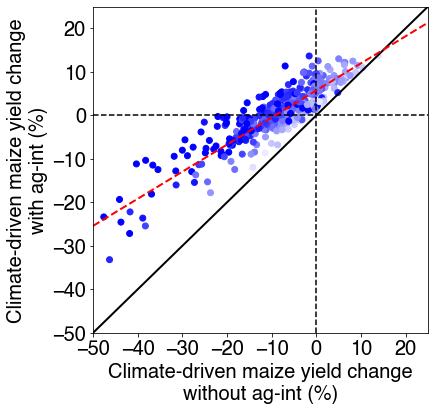

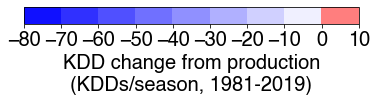

In [83]:
nnAgInt = adjNn[np.where(~np.isnan((maizeYieldChgFeedbackWithAgInt[adjNn, 0, 0]*NYears/10)/np.nanmean(countyMaizeYield[adjNn], axis=1)*100))[0]]
nnNoAgInt = adjNn[np.where(~np.isnan((maizeYieldChgFeedbackWithoutAgInt[adjNn, 0, 0]*NYears/10)/np.nanmean(countyMaizeYield[adjNn], axis=1)*100))[0]]

maizeYieldChgAgInt = (np.nanmean(np.nanmean(maizeYieldChgFeedbackWithAgInt[nnAgInt, :, :], axis=2), axis=1)*NYears/10)/np.nanmean(countyMaizeYield[nnAgInt], axis=1)*100
maizeYieldChgNoAgInt = (np.nanmean(np.nanmean(maizeYieldChgFeedbackWithoutAgInt[nnNoAgInt, :, :], axis=2), axis=1)*NYears/10)/np.nanmean(countyMaizeYield[nnNoAgInt], axis=1)*100

X = sm.add_constant(maizeYieldChgNoAgInt)
mdl = sm.OLS(maizeYieldChgAgInt, X).fit()

x1 = -50
x2 = 25

kddChg = (np.nanmean(np.nanmean(kddChgFeedbackWithAgInt[nnAgInt, :, :], axis=2), axis=1)*NYears/10)-(np.nanmean(np.nanmean(kddChgFeedbackWithoutAgInt[nnNoAgInt, :, :], axis=2), axis=1)*NYears/10)

midnorm = MidpointNormalize(vmin=-80, vcenter=0, vmax=10)

fig = plt.figure(figsize=(6,6))
plt.xlim([-50, 25])
plt.ylim([-50, 25])
a = plt.scatter(maizeYieldChgNoAgInt, maizeYieldChgAgInt, c=kddChg, cmap='bwr', norm=midnorm)
plt.plot([-50, 25], [0, 0], '--k', lw=1.5)
plt.plot([0, 0], [-50, 25], '--k', lw=1.5)
plt.plot([-50, 25], [-50, 25], '-k', lw=2)

plt.plot([x1, x2], [mdl.params[0]+x1*mdl.params[1], mdl.params[0]+x2*mdl.params[1]], '--r', lw=2)

plt.ylabel('Climate-driven maize yield change\nwith ag-int (%)', fontsize=20)
plt.xlabel('Climate-driven maize yield change\nwithout ag-int (%)', fontsize=20)
plt.yticks([-50, -40, -30, -20, -10, 0, 10, 20], fontsize=20)
plt.xticks([-50, -40, -30, -20, -10, 0, 10, 20], fontsize=20)

# if useDeepak:
#     plt.savefig('maize-yield-chg-with-and-without-feedback-scatter-deepak-%s.png'%wxData, format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.01)
# else:
#     plt.savefig('maize-yield-chg-with-and-without-feedback-scatter-nass-%s.png'%wxData, format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.01)

fig = plt.figure()
plt.gca().set_visible(False)

cbar = fig.colorbar(a, ax=plt.gca(), orientation='horizontal', 
                    ticks=np.arange(-80, 11, 10), boundaries=np.arange(-80, 11, 10))
cbar.set_label('KDD change from production\n(KDDs/season, 1981-2019)', fontsize=20)
cbar.ax.tick_params(labelsize=20)

# if useDeepak:
#     plt.savefig('maize-yield-chg-with-and-without-feedback-scatter-colorbar-deepak-%s.png'%wxData, format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0)
# else:
#     plt.savefig('maize-yield-chg-with-and-without-feedback-scatter-colorbar-nass-%s.png'%wxData, format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0)


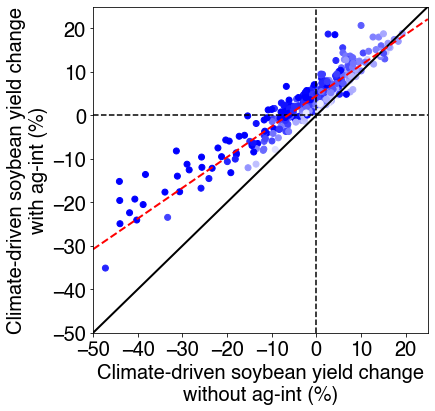

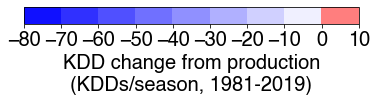

In [84]:

nnAgInt = adjNn[np.where(~np.isnan((soybeanYieldChgFeedbackWithAgInt[adjNn, 0, 0]*NYears/10)/np.nanmean(countySoybeanYield[adjNn], axis=1)*100))[0]]
nnNoAgInt = adjNn[np.where(~np.isnan((soybeanYieldChgFeedbackWithoutAgInt[adjNn, 0, 0]*NYears/10)/np.nanmean(countySoybeanYield[adjNn], axis=1)*100))[0]]


soybeanYieldChgAgInt = (np.nanmean(np.nanmean(soybeanYieldChgFeedbackWithAgInt[nnAgInt, :, :], axis=2), axis=1)*NYears/10)/np.nanmean(countySoybeanYield[nnAgInt], axis=1)*100
soybeanYieldChgNoAgInt = (np.nanmean(np.nanmean(soybeanYieldChgFeedbackWithoutAgInt[nnNoAgInt, :, :], axis=2), axis=1)*NYears/10)/np.nanmean(countySoybeanYield[nnNoAgInt], axis=1)*100

X = sm.add_constant(soybeanYieldChgNoAgInt)
mdl = sm.OLS(soybeanYieldChgAgInt, X).fit()

x1 = -50
x2 = 25

kddChg = (np.nanmean(np.nanmean(kddChgFeedbackWithAgInt[nnAgInt, :, :], axis=2), axis=1)*NYears/10)-(np.nanmean(np.nanmean(kddChgFeedbackWithoutAgInt[nnNoAgInt, :, :], axis=2), axis=1)*NYears/10)

midnorm = MidpointNormalize(vmin=-80, vcenter=0, vmax=10)

fig = plt.figure(figsize=(6,6))
plt.xlim([-50, 25])
plt.ylim([-50, 25])
a = plt.scatter(soybeanYieldChgNoAgInt, soybeanYieldChgAgInt, c=kddChg, cmap='bwr', norm=midnorm)
plt.plot([-50, 25], [0, 0], '--k', lw=1.5)
plt.plot([0, 0], [-50, 25], '--k', lw=1.5)
plt.plot([-50, 25], [-50, 25], '-k', lw=2)

plt.plot([x1, x2], [mdl.params[0]+x1*mdl.params[1], mdl.params[0]+x2*mdl.params[1]], '--r', lw=2)

plt.ylabel('Climate-driven soybean yield change\nwith ag-int (%)', fontsize=20)
plt.xlabel('Climate-driven soybean yield change\nwithout ag-int (%)', fontsize=20)
plt.yticks([-50, -40, -30, -20, -10, 0, 10, 20], fontsize=20)
plt.xticks([-50, -40, -30, -20, -10, 0, 10, 20], fontsize=20)

# if useDeepak:
#     plt.savefig('soybean-yield-chg-with-and-without-feedback-scatter-deepak-%s.png'%wxData, format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.01)
# else:
#     plt.savefig('soybean-yield-chg-with-and-without-feedback-scatter-nass-%s.png'%wxData, format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.01)

fig = plt.figure()
plt.gca().set_visible(False)

cbar = fig.colorbar(a, ax=plt.gca(), orientation='horizontal', 
                    ticks=np.arange(-80, 11, 10), boundaries=np.arange(-80, 11, 10))
cbar.set_label('KDD change from production\n(KDDs/season, 1981-2019)', fontsize=20)
cbar.ax.tick_params(labelsize=20)

# if useDeepak:
#     plt.savefig('soybean-yield-chg-with-and-without-feedback-scatter-colorbar-deepak-%s.png'%wxData, format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0)
# else:
#     plt.savefig('soybean-yield-chg-with-and-without-feedback-scatter-colorbar-nass-%s.png'%wxData, format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0)


In [85]:
print('maize quad TL: %.2f'%(len(np.where((maizeYieldChgNoAgInt<0) & (maizeYieldChgAgInt>0))[0])/len(maizeYieldChgNoAgInt)))
print('soybean quad TL: %.2f'%(len(np.where((soybeanYieldChgNoAgInt<0) & (soybeanYieldChgAgInt>0))[0])/len(soybeanYieldChgNoAgInt)))

print('maize quad BL: %.2f'%(len(np.where((maizeYieldChgNoAgInt<0) & (maizeYieldChgAgInt<0))[0])/len(maizeYieldChgNoAgInt)))
print('soybean quad BL: %.2f'%(len(np.where((soybeanYieldChgNoAgInt<0) & (soybeanYieldChgAgInt<0))[0])/len(soybeanYieldChgNoAgInt)))

print('maize quad TR: %.2f'%(len(np.where((maizeYieldChgNoAgInt>0) & (maizeYieldChgAgInt>0))[0])/len(maizeYieldChgNoAgInt)))
print('soybean quad TR: %.2f'%(len(np.where((soybeanYieldChgNoAgInt>0) & (soybeanYieldChgAgInt>0))[0])/len(soybeanYieldChgNoAgInt)))

maize quad TL: 0.39
soybean quad TL: 0.27
maize quad BL: 0.44
soybean quad BL: 0.25
maize quad TR: 0.16
soybean quad TR: 0.48


In [ ]:
nnAgInt = adjNn[np.where(~np.isnan((maizeYieldChgFeedbackWithAgInt[adjNn]*NYears/10)/np.nanmean(countyMaizeYield[adjNn], axis=1)*100))[0]]
nnNoAgInt = adjNn[np.where(~np.isnan((maizeYieldChgFeedbackWithoutAgInt[adjNn]*NYears/10)/np.nanmean(countyMaizeYield[adjNn], axis=1)*100))[0]]

netRadChg = np.nanmean((netRadObsTrend[nnAgInt]*NYears/10)/np.nanmean(countyNetRad[nnAgInt, :], axis=1)*100)
netRadErr = np.nanstd((netRadObsTrend[nnAgInt]*NYears/10)/np.nanmean(countyNetRad[nnAgInt, :], axis=1)*100)

lhChg = [np.nanmean(lhChgFeedbackWithoutAgInt[nnAgInt]*NYears/10/np.nanmean(countySlhf[nnAgInt,:], axis=1))*100, \
         np.nanmean(lhChgFeedbackWithAgInt[nnAgInt]*NYears/10/np.nanmean(countySlhf[nnAgInt,:], axis=1))*100]
lhErr = [np.nanstd(lhChgFeedbackWithoutAgInt[nnAgInt]*NYears/10/np.nanmean(countySlhf[nnAgInt,:], axis=1)*100), \
         np.nanstd(lhChgFeedbackWithAgInt[nnAgInt]*NYears/10/np.nanmean(countySlhf[nnAgInt,:], axis=1)*100)]

lhObsChg = [np.nanmean((lhObsTrend[nnAgInt]*NYears/10)/np.nanmean(countySlhf[nnAgInt,:], axis=1)*100)]
lhObsErr = [np.nanstd((lhObsTrend[nnAgInt]*NYears/10)/np.nanmean(countySlhf[nnAgInt,:], axis=1)*100)]

shChg = [np.nanmean(shChgFeedbackWithoutAgInt[nnAgInt]*NYears/10/np.nanmean(countySshf[nnAgInt,:], axis=1))*100, \
         np.nanmean(shChgFeedbackWithAgInt[nnAgInt]*NYears/10/np.nanmean(countySshf[nnAgInt,:], axis=1))*100]
shErr = [np.nanstd(shChgFeedbackWithoutAgInt[nnAgInt]*NYears/10/np.nanmean(countySshf[nnAgInt,:], axis=1)*100), \
         np.nanstd(shChgFeedbackWithAgInt[nnAgInt]*NYears/10/np.nanmean(countySshf[nnAgInt,:], axis=1)*100)]


labels = ['Net\nRadiation', 'Latent\nHeat', 'Sensible\nHeat']

x = [1,2,3]
width = .35
plt.figure(figsize=(6,6))
plt.ylim([.5, 3.5])

plt.barh([1], netRadChg, height=width, xerr=netRadErr, capsize=3, error_kw={'lw':1}, facecolor='gray', label='Observed')
plt.plot(netRadChg, [1], 'ok', markersize=5)

plt.barh([2-width/2], lhChg[0], height=width, xerr=lhErr[0], capsize=3, error_kw={'lw':1}, facecolor='#e34627', label='No ag-int')
plt.plot(lhChg[0], [2-width/2], 'ok', markersize=5)
plt.barh([2+width/2], lhChg[1], height=width, xerr=lhErr[1], capsize=3, error_kw={'lw':1}, facecolor='#19a651', label='With ag-int')
plt.plot(lhChg[1], [2+width/2], 'ok', markersize=5)

plt.barh([3-width/2], shChg[0], height=width, xerr=shErr[0], capsize=3, error_kw={'lw':1}, facecolor='#e34627')
plt.plot(shChg[0], [3-width/2], 'ok', markersize=5)
plt.barh([3+width/2], shChg[1], height=width, xerr=shErr[1], capsize=3, error_kw={'lw':1}, facecolor='#19a651')
plt.plot(shChg[1], [3+width/2], 'ok', markersize=5)

plt.plot([0, 0], [.5, 3.5], '-k', lw=1)

plt.gca().set_yticks(x)
plt.gca().set_yticklabels(labels, fontsize=20)

plt.xlabel('U.S. mean change (%, 1981-2019)', fontsize=20)
plt.xticks(range(-20, 81, 10), fontsize=20)

plt.gca().invert_yaxis()  # labels read top-to-bottom

l1 = plt.legend(prop = {'size':16, 'family':'Helvetica'}, loc='upper right')
l1.get_frame().set_linewidth(0)


In [86]:
scipy.stats.ks_2samp(maizeYieldChgAgInt, maizeYieldChgNoAgInt)

Ks_2sampResult(statistic=0.48158640226628896, pvalue=1.9154715300362132e-37)

In [87]:
# calculate the fraction of yield trend explained by feedback over upper midwest to compare with Butler et al PNAS 
# (but only the 'climate' component, not changes to growing season length)

print('fraction of trend from ag-int in upper midwest')
inds = []
for si, s in enumerate(stateSel):
    if s in ['IA', 'MN', 'SD', 'NE', 'WI', 'IL', 'IN', 'MI', 'OH', 'KY', 'MO']:
        inds.append(si)
inds = np.array(inds)
print('maize: %.2f%%'%np.nanmean(np.nanmean(np.nanmean(maizeYieldTrendFrac[inds, :, :]))))

inds = []
for si, s in enumerate(stateSel):
    if s in ['IA', 'MN', 'SD', 'NE', 'WI', 'IL', 'IN', 'MI', 'OH', 'KY', 'MO']:
        inds.append(si)
inds = np.array(inds)
print('soybean: %.2f%%'%np.nanmean(np.nanmean(np.nanmean(soybeanYieldTrendFrac[inds, :, :]))))

fraction of trend from ag-int in upper midwest


NameError: name 'stateSel' is not defined